In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
from copy import deepcopy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, StratifiedShuffleSplit, cross_val_score, cross_val_predict, GridSearchCV, LeaveOneOut
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.externals import joblib
from collections import Counter

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Загрузка данных

In [4]:
labels = pd.read_csv("targets 22.03.2018.csv", sep=";")
mri_data = pd.read_csv("features_ttest.csv",index_col=0)

In [5]:
mri_data.drop(['patient','target'],axis=1, inplace=True)

In [6]:
mri_data.head()

,degree_Precentral_L,degree_Precentral_R,degree_Frontal_Sup_L,degree_Frontal_Sup_R,degree_Frontal_Sup_Orb_L,degree_Frontal_Sup_Orb_R,degree_Frontal_Mid_L,degree_Frontal_Mid_R,degree_Frontal_Mid_Orb_L,degree_Frontal_Mid_Orb_R,...,path_length_Vermis_4_5,path_length_Vermis_6,path_length_Vermis_7,path_length_Vermis_8,path_length_Vermis_9,path_length_Vermis_10,path_length_0,average_clustering,local_efficiency,global_efficiency
0,61.0,45.0,54.0,52.0,56.0,53.0,48.0,58.0,57.0,48.0,...,148.0,149.0,154.0,0.0,0.0,0.0,0.0,0.470570,0.674332,0.567271
1,32.0,40.0,38.0,35.0,34.0,0.0,0.0,34.0,34.0,0.0,...,0.0,105.0,0.0,0.0,0.0,0.0,0.0,0.310681,0.440407,0.233790
2,63.0,56.0,76.0,73.0,76.0,68.0,45.0,52.0,68.0,49.0,...,169.0,162.0,158.0,174.0,160.0,161.0,161.0,0.558251,0.768911,0.715886
3,57.0,56.0,54.0,51.0,47.0,45.0,50.0,59.0,53.0,57.0,...,143.0,142.0,155.0,0.0,0.0,0.0,0.0,0.448466,0.659806,0.545977
4,39.0,45.0,40.0,44.0,43.0,0.0,0.0,44.0,46.0,0.0,...,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.348689,0.461941,0.252137


In [7]:
idx_to_label = ["C", "D", "E", "DE", "NE", "ND", "TLE", "Positive", "Negative", "TLEPositive", "TLENegative", "NoTLE"]
label_to_idx = {l : i for i, l in enumerate(idx_to_label)}

for col in labels.columns[1:]:
    labels[col] = labels[col].apply(lambda x: label_to_idx[x] if x in label_to_idx else np.nan)
    
DE_idx = labels["target"].notnull()
E_idx = labels["E/no E"].notnull()
D_idx = labels["D/no D"].notnull()
E_C_idx = labels["E/C"].notnull()
TLE_noE_idx = labels["TLE/no E"].notnull()
TLE_C_idx = labels["TLE/C"].notnull()
D_C_idx = labels["D/C"].notnull()
DE_E_idx = labels["DE/E"].notnull()
Pos_Neg_idx = np.logical_and(labels["MRIPositive/Negative "].notnull(), labels["E/no E"] == label_to_idx["E"])
TLEPos_C_idx = labels["TLEPositive/C"].notnull()
TLENeg_C_idx = labels["TLENegative/C"].notnull()
NoTLE_C_idx = labels["NoTLE/C"].notnull()
# +
DE_D_idx = labels["D/no D"] == label_to_idx["D"]
labels["DE/D"] = labels["target"][DE_D_idx]

In [8]:
len(mri_data)

100

In [9]:
len(labels)

100

In [10]:
# отбор признаков на основе модели
# аналогично SelectFromModel, но на основе количества признаков, а не порога

from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone
from sklearn.feature_selection.base import SelectorMixin
from sklearn.feature_selection.from_model import _get_feature_importances
from sklearn.utils.metaestimators import if_delegate_has_method

class SelectNFeaturesFromModel(BaseEstimator, SelectorMixin, MetaEstimatorMixin):
    def __init__(self, estimator, n_selected, prefit=False):
        self.estimator = estimator
        self.n_selected = n_selected
        self.prefit = prefit

    def _get_support_mask(self):
        if self.prefit:
            estimator = self.estimator
        elif hasattr(self, 'estimator_'):
            estimator = self.estimator_
        else:
            raise ValueError(
                'Either fit SelectFromModel before transform or set "prefit='
                'True" and pass a fitted estimator to the constructor.')
        scores = _get_feature_importances(estimator)
        threshold = np.sort(scores)[-self.n_selected]
        return scores >= threshold

    def fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(X, y, **fit_params)
        return self
    
    @property
    def scores_(self):
        scores = _get_feature_importances(self.estimator_,)
        return scores

    @property
    def threshold_(self):
        scores = _get_feature_importances(self.estimator_,)
        return np.sort(scores)[-n_selected]
    
    @if_delegate_has_method('estimator')
    def partial_fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        if not hasattr(self, "estimator_"):
            self.estimator_ = clone(self.estimator)
        self.estimator_.partial_fit(X, y, **fit_params)
        return self

In [11]:
from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone
from sklearn.feature_selection.base import SelectorMixin
from sklearn.feature_selection.from_model import _get_feature_importances
from sklearn.utils.metaestimators import if_delegate_has_method

class SelectFromGroups(BaseEstimator, SelectorMixin, MetaEstimatorMixin):
    # groups = True-False-mask for X columns (features)
    def __init__(self, method, groups=[]):
        self.method = method
        self.groups = groups
        self.methods = []
        self.supports = []
        
    def _get_support_mask(self):
#         if self.prefit:
#             estimator = self.estimator
#         elif hasattr(self, 'estimator_'):
#             estimator = self.estimator_
#         else:
#             raise ValueError(
#                 'Either fit SelectFromModel before transform or set "prefit='
#                 'True" and pass a fitted estimator to the constructor.')
#         scores = _get_feature_importances(estimator)
#         threshold = np.sort(scores)[-self.n_selected]
        return np.column_stack(supports)
        
    def fit(self, X, y):
        self.methods = []
        self.supports = []
        if not self.groups:
            n_features = X.shape[1]
            self.groups = [np.ones(n_features, dtype=bool)]
        for group in self.groups:
            self.method.fit(X[:, group], y)
            self.methods.append(deepcopy(self.method))
            self.supports.append(self.method.get_support())
                
    def fit_transform(self, X, y):
        self.methods = []
        self.supports = []
        transformed = []
        if not self.groups:
            n_features = X.shape[1]
            self.groups = [np.ones(n_features, dtype=bool)]
        for group in self.groups:
            transformed.append(self.method.fit_transform(X[:, group], y))
            self.methods.append(deepcopy(self.method))
            self.supports.append(self.method.get_support())
                
        return np.column_stack(transformed)
    def transform(self, X):
        transformed = []
        if not self.methods:
            self.method.transform(X)
        else:
            for group in self.groups:
                transformed.append(self.method.transform(X[:, group]))
        return np.column_stack(transformed)

In [12]:
def get_svc_grid(cv, dim_reduction_methods, scoring, random_state=None, n_jobs=1,
                 svc_kernel_l=None, svc_c_l=None, svc_gamma_l=None):

    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
#         ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', SVC(probability=True, random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if svc_kernel_l is not None:
        param_grid['classifier__kernel'] = svc_kernel_l
    if svc_c_l is not None:
        param_grid['classifier__C'] = svc_c_l
    if svc_gamma_l is not None:
        param_grid['classifier__gamma'] = svc_gamma_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)

In [13]:
def get_lr_grid(cv, dim_reduction_methods, scoring, random_state=None, n_jobs=1,
                 lr_c_l=None, lr_penalty_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
#         ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', LogisticRegression(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if lr_c_l is not None:
        param_grid['classifier__C'] = lr_c_l
    if lr_penalty_l is not None:
        param_grid['classifier__penalty'] = lr_penalty_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)

In [14]:
def get_rfc_grid(cv, dim_reduction_methods, scoring, random_state=None, n_jobs=1,
                 rfc_n_estimators_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
#         ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', RandomForestClassifier(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if rfc_n_estimators_l is not None:
        param_grid['classifier__n_estimators'] = rfc_n_estimators_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)

In [15]:
def get_knn_grid(cv, dim_reduction_methods, scoring, random_state=None, n_jobs=1,
                 knn_n_neighbors_l=None, knn_weights_l=None, knn_p_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
#         ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', KNeighborsClassifier()),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if knn_n_neighbors_l is not None:
        param_grid['classifier__n_neighbors'] = knn_n_neighbors_l
    if knn_weights_l is not None:
        param_grid['classifier__weights'] = knn_weights_l
    if knn_p_l is not None:
        param_grid['classifier__p'] = knn_p_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)

In [16]:
def get_gbc_grid(cv, dim_reduction_methods, scoring, random_state=None, n_jobs=1,
                 gbc_n_estimators_l=None): # мб нужно варьировать больше параметров
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
#         ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', GradientBoostingClassifier(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if gbc_n_estimators_l is not None:
        param_grid['classifier__n_estimators'] = gbc_n_estimators_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)

In [17]:
# set printoptions
pd.set_option('expand_frame_repr', True)
pd.set_option('max_colwidth', 150)

In [18]:
def print_results(clf_grid_dict, save_plot_to=None):
    results = {
            "classifier" : [], 
            "best parameters" : [],
            "best dim. reduction method" : [],
            "mean" : [],
            "std" : []
           }
    
    for clf, grid in clf_grid_dict.items():
        results["classifier"].append(clf)
        results["best parameters"].append(", ".join(
            [param + " = " + str(best_value) for param, best_value in grid.best_params_.items() if param != 'dim_reduction']))
        results["best dim. reduction method"].append(grid.best_params_['dim_reduction'])
        idx = grid.best_index_
        results["mean"].append(grid.cv_results_['mean_test_score'][idx])
        results["std"].append(grid.cv_results_['std_test_score'][idx])
        
    results = pd.DataFrame(results, columns=["classifier", "best parameters", "best dim. reduction method", "mean", "std"])
    display(results.set_index("classifier"))
    
    # draw graph
    width = 0.9
    for i in results.index:
        plt.bar(i, results.loc[i, "mean"], width, yerr=results.loc[i, "std"], label=results.loc[i, "classifier"])
    plt.xticks(range(results.shape[0]), results.loc[:, "classifier"])
    plt.axis(ymin=0.0, ymax=1.0)
    if save_plot_to is not None:
        plt.savefig(save_plot_to)
    plt.show()
    
    print("Best model: ")
    clf = results.loc[results["mean"].argmax(), "classifier"]
    print(clf)
    print("\n".join(
            [param + " = " + str(best_value) for param, best_value in clf_grid_dict[clf].best_params_.items()]))

### Объединенный подсчет и сравнение всех классификаторов (SVC, LR, RFC, KNN, GBC)

In [19]:
def train_grid_cv(X, y, n_splits, n_repeats, scoring, pos_label=None, random_state=None, n_jobs=1, features_groups=[], save_plot_to=None):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    
    #n_features = [10, 20, 50, 100]
    n_features = [20]
    n_components = [10, 20]
    
    # list of dimensionality reduction methods
    dim_reduction_methods = []
    dim_reduction_methods += [SelectKBest(stats.ttest_ind, n) for n in n_features]
    dim_reduction_methods += [SelectKBest(f_classif, n) for n in n_features]
    dim_reduction_methods += [SelectNFeaturesFromModel(RandomForestClassifier(n_estimators=100, random_state=random_state), n) for n in n_features]
    dim_reduction_methods += [SelectNFeaturesFromModel(LogisticRegression(random_state=random_state), n) for n in n_features]
    dim_reduction_methods += [SelectNFeaturesFromModel(ExtraTreesClassifier(n_estimators=100, random_state=random_state), n) for n in n_features]
#     dim_reduction_methods += [PCA(n, random_state=random_state) for n in n_components]
#     dim_reduction_methods += [LocallyLinearEmbedding(n_components=n, random_state=random_state) for n in n_components]
    
    
    print("Target distribution: ")
    print(y.value_counts(), "\n")
    if pos_label is None:
        y_enc = pd.Series(LabelEncoder().fit_transform(y), index=y.index)
    else:
        y_enc = pd.Series(y == pos_label, dtype=int)
    
    print("Training SVC...")
    grid_cv_svc = get_svc_grid(cv, dim_reduction_methods, scoring, random_state=random_state, n_jobs=n_jobs,
                               svc_kernel_l=["rbf", "linear"],
                               svc_c_l=[10 ** i for i in range(0, 4, 1)],
                               svc_gamma_l=[10 ** i for i in range(-3, -1, 1)])
    start_time = time.time()
    grid_cv_svc.fit(X, y_enc)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training LR...")
    grid_cv_lr = get_lr_grid(cv, dim_reduction_methods, scoring, random_state=random_state, n_jobs=n_jobs,
                             lr_c_l=[10 ** i for i in range(-4, -1, 1)],
                             lr_penalty_l=["l1", "l2"])
    start_time = time.time()
    grid_cv_lr.fit(X, y_enc)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training RFC...")
    grid_cv_rfc = get_rfc_grid(cv, dim_reduction_methods, scoring, random_state=random_state, n_jobs=n_jobs,
                               rfc_n_estimators_l=[i for i in range(100, 210, 30)])
    start_time = time.time()
    grid_cv_rfc.fit(X, y_enc)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training KNN...")
    class_size_tr = min(y.value_counts())
    grid_cv_knn = get_knn_grid(cv, dim_reduction_methods, scoring, random_state=random_state, n_jobs=n_jobs,
                              knn_p_l=[1, 2],
                              knn_weights_l=["uniform", "distance"],
                              knn_n_neighbors_l=[i for i in range(5, class_size_tr - 1, 3)])
    start_time = time.time()
    grid_cv_knn.fit(X, y_enc)
    print("(training took {}s)\n".format(time.time() - start_time))

    
    print("Scoring:", scoring)
    print_results({
        "SVC" : grid_cv_svc,
        "LR" : grid_cv_lr,
        "RFC" : grid_cv_rfc,
        "KNN" : grid_cv_knn,
                  }, save_plot_to=save_plot_to)
    
    best_model = max([grid_cv_svc, grid_cv_lr, grid_cv_rfc, grid_cv_knn], key=lambda x: x.best_score_).best_estimator_
    
    return best_model, grid_cv_svc, grid_cv_lr, grid_cv_rfc, grid_cv_knn

In [20]:
n_objects = mri_data.shape[0]

def repeated_cross_val_predict(estimator, X, y, cv, file=None):
    predictions = [[] for i in range(n_objects)]
    for idx_tr, idx_te in tqdm(cv.split(X, y)):
        estimator.fit(X.iloc[idx_tr], y.iloc[idx_tr])
        pred_te = np.array(estimator.predict(X.iloc[idx_te]), dtype=int)
        for i, idx in enumerate(idx_te):
            predictions[X.index[idx]].append(idx_to_label[pred_te[i]])
        
    predictions = pd.DataFrame(predictions)
    if file is not None:
        predictions.to_csv(file)
        
    return predictions

In [21]:
n_objects = mri_data.shape[0]

def repeated_cross_val_predict_proba(estimator, X, y, cv, pos_label=None, file=None):
    
    if pos_label is None:
        y_enc = pd.Series(LabelEncoder().fit_transform(y), index=y.index)
    else:
        y_enc = pd.Series(y == pos_label, dtype=int)
    predictions = [[] for i in range(n_objects)]
    for idx_tr, idx_te in tqdm(cv.split(X, y_enc)):
        estimator.fit(X.iloc[idx_tr], y_enc.iloc[idx_tr])
        pred_te = np.array(estimator.predict_proba(X.iloc[idx_te]), dtype=float)
        for i, idx in enumerate(idx_te):
            predictions[X.index[idx]].append(pred_te[i, 1])
        
    predictions = pd.DataFrame(predictions)
    if file is not None:
        predictions.to_csv(file)
        
    return predictions

In [22]:
def save_model(model, file):
    joblib.dump(model, file)
    
def load_model(file):
    model = joblib.load(file)
    return model

In [23]:
def plot_roc_curve(y, probas, idx, average_repeats=False, show=True):
    if average_repeats:
        y_true = y
        y_score = probas[idx].mean(axis=1)
    else:
        n_repeats = probas.shape[1]
        y_true = pd.Series(np.tile(y, (n_repeats)), dtype=int)
        y_score = probas[idx].values.T.reshape(-1, 1)
    fpr, tpr, t = roc_curve(y_true=y_true, y_score=y_score)
    
    if show:
        plt.figure(figsize=(12, 8))
        plt.plot(fpr, tpr)
        plt.xlabel("False Positive rate", fontsize=14)
        plt.ylabel("True Positive rate", fontsize=14)
        plt.show()
        print("auc =", roc_auc_score(y_true, y_score))
        
    return fpr, tpr, t

In [24]:
def get_fixed_fpr_threshold(fpr, t, fix_fpr=0):
    return t[fpr <= fix_fpr][-1]

In [25]:
def get_fpr_fnr(fpr, tpr, fix_fpr_l=[0.1, 0.15, 0.2, 0.3]):
    fnr_l = []
    for fix_fpr in fix_fpr_l:
        fnr_l.append(1 - tpr[fpr <= fix_fpr][-1])
    fpr_fnr_table = pd.DataFrame(np.column_stack((fix_fpr_l, fnr_l)), columns=["False Positive rate (fixed)", "False Negative rate"])
    display(fpr_fnr_table)
    return fpr_fnr_table

In [26]:
# сейчас работает только для одномерных векторов вероятностей (одно предсказание для каждого объекта, напр. leave one out)
def get_incorrectly_classified(y, probas, idx, fpr, t, fix_fpr_l=[0.1, 0.15, 0.2, 0.3], file=None, show=True):
    columns = ["False Positive rate (fixed)", "Threshold", "False Positives indexes", "False Negatives indexes"]
    t_l = []
    false_0 = []
    false_1 = []
    for fix_fpr in fix_fpr_l:
        fix_t = t[fpr <= fix_fpr][-1]
        t_l.append(fix_t)
        labels_t = probas > fix_t
        labels_t = pd.Series(labels_t.values.ravel())
        false_0.append(", ".join(list(labels.loc[(probas[idx][np.logical_and(labels_t[idx] == 0, y == 1)]).index, "patient_number"])))
        false_1.append(", ".join(list(labels.loc[(probas[idx][np.logical_and(labels_t[idx] == 1, y == 0)]).index, "patient_number"])))
              
    t_l = np.array(t_l)
    false_0 = np.array(false_0)
    false_1 = np.array(false_1)
    
    res = pd.DataFrame(np.column_stack((fix_fpr_l, t_l)), columns=columns[:2])
    res["False Positives indexes"] = false_1
    res["False Negatives indexes"] = false_0
    
    if file is not None:
        res.to_csv(file)
        
    if show:
        display(res)
    return res

In [27]:
def get_features(X, y, model):
    model.fit(X, y)
#     var_th = model.named_steps['VarTh']
#     var_th_features_idx = var_th.get_support()
    dim_reduction = model.named_steps["dim_reduction"]
    features_idx = dim_reduction.get_support()
#     classifier = model.named_steps["classifier"]
#     features_weights = classifier.coef_[0]
    features = X.columns[features_idx].tolist()
    return features

In [28]:
def get_feature_sets_on_cross_val(X, y, model, cv):
    feature_sets = []
    for idx_tr, idx_te in tqdm(cv.split(X, y)):
        X_tr = X.loc[X.index[idx_tr]]
        y_tr = y.loc[X.index[idx_tr]]
        y_te = y.loc[X.index[idx_te]]
        feature_sets.append(get_features(X_tr, y_tr, model))
    return feature_sets

In [29]:
def get_frequent_features(features_l, classifier_l, y, p=0.5, min_common=3, file_all=None, file_frequent=None):
    for i, features in enumerate(features_l):
        features["frequency_norm"] = features["frequency"] / y.size
        features["classifier"] = classifier_l[i]
    
    all_features = pd.concat([features.drop("frequency", axis=1) for features in features_l], axis=0)
    all_features = all_features.reset_index().set_index("classifier")
    all_features.columns = ["feature", "frequency_norm"]
    
    if file_all is not None:
        all_features.to_csv(file_all)
        
    frequent_features = pd.DataFrame(all_features[all_features.frequency_norm > p]["feature"].value_counts())
    if file_frequent is not None:
        frequent_features.to_csv(file_frequent)
    
    common_frequent_features = frequent_features[frequent_features["feature"] >= min_common].index.tolist()
    
    return all_features, frequent_features, common_frequent_features

In [30]:
def get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False, file=None):
    incorr_classified_l = []
    for i, probas in enumerate(probas_l):
        fpr, tpr, t = plot_roc_curve(y, probas, idx, show=show)
        incorr_classified = get_incorrectly_classified(y, probas, idx, fpr, t, show=show)
        incorr_classified["classifier"] = classifiers_l[i]
        incorr_classified_l.append(incorr_classified)
        
    all_incorr_classified = pd.concat(incorr_classified_l, axis=0)
    all_incorr_classified.set_index("classifier", inplace=True)
    
    if file is not None:
        all_incorr_classified.to_csv(file)
    
    max_fpr = all_incorr_classified["False Positive rate (fixed)"].max()
    common_false_positives = Counter(list((", ".join(all_incorr_classified[all_incorr_classified["False Positive rate (fixed)"] == max_fpr]["False Positives indexes"].tolist())).split(", ")))
    data=pd.DataFrame(common_false_positives,index=[0]).T
    common_false_positives_ =", ".join(data[data[0]>=3].index)    
    
    min_fpr = all_incorr_classified["False Positive rate (fixed)"].min()
    common_false_negatives = Counter(list((", ".join(all_incorr_classified[all_incorr_classified["False Positive rate (fixed)"] == min_fpr]["False Negatives indexes"].tolist())).split(", ")))
    data=pd.DataFrame(common_false_negatives,index=[0]).T
    common_false_negatives_ =", ".join(data[data[0]>=3].index)
    
    return all_incorr_classified, common_false_positives_, common_false_negatives_

In [31]:
def get_frequent_regions(all_features, n=0.0, importance=0.5):
    freq_list=all_features[all_features['frequency_norm']>=n]
    freq_list=freq_list.reset_index()
    freq_list['feature_pure']=''
    freq_list['feature_score']=''
    appendix_list_thick=['_NumVert','_GrayVol','_FoldInd','_CurvInd','_GausCurv','_ThickStd','_ThickAvg','_MeanCurv','_SurfArea']
    appendix_list_vol=['_Volume_mm3','_normMean','_normMin','_normMax','_normStdDev','_normRange','_NVoxels']
    for i in range(len(freq_list)):
        for j in appendix_list_thick:
            if j in freq_list['feature'].loc[i]:
                freq_list['feature_pure'].loc[i]=freq_list['feature'].loc[i].replace(j, '')
                freq_list['feature_score'].loc[i]=freq_list['frequency_norm'].loc[i]/9
        for k in appendix_list_vol:
            if k in freq_list['feature'].loc[i]:
                freq_list['feature_pure'].loc[i]=freq_list['feature'].loc[i].replace(k, '')
                freq_list['feature_score'].loc[i]=freq_list['frequency_norm'].loc[i]/7

    freq_pure_list=freq_list[['feature_pure','feature_score']].groupby(['feature_pure']).sum()
    freq_pure_list=freq_pure_list.sort_values(['feature_score'], ascending=False)
    freq_pure_list=freq_pure_list[freq_pure_list['feature_score']>=freq_pure_list['feature_score'].max()*importance]
    print (freq_pure_list)

In [32]:
# now going with test train validate
def select_features_on_cross_val(cv, X_tr, y_tr, random_state=None):
    # отбираем признаки    
    # сохраняем все признаки с весами (для каждой итерации RepeatedKFold)
    features_l = []
    for i_tr, i_te in cv.split(X_tr, y_tr):
        
        selector = SelectKBest(score_func=f_classif, k=150)
        selector.fit(X_tr.loc[X_tr.index[i_tr]], y_tr[X_tr.index[i_tr]])
        features_idx = selector.get_support()
        features = X_tr.columns[features_idx].tolist()
#         selector = LogisticRegression(penalty='l1', random_state=random_state)
#         selector.fit(X_tr.loc[X_tr.index[i_tr]], y_tr[X_tr.index[i_tr]])
#         features_weights = selector.coef_[0]
#         features = pd.DataFrame(sorted(list(zip(X_tr.columns, features_weights)), 
#                         key=lambda x: -abs(x[1])), columns=["feature", "weight (from classifier)"])
#         # оставляем только признаки с ненулевыми весами
#         features = features.loc[features["weight (from classifier)"] != 0, "feature"].values.tolist()
        features_l.append(features)

    # оставляем только признаки, которые вошли во все множества 
    selected_features = list(reduce(lambda x, y: set(x) & set(y), features_l))
#     print(selected_features)

    # оставляем области, которые вошли во все множества
    regions_l = list(map(lambda x: list(map(get_feature_region, x)), features_l))
    selected_regions = list(reduce(lambda x, y: set(x) & set(y), regions_l))
#     print(selected_regions)
    
    # выбираем все признаки для этих областей
    selected = []
    for region in selected_regions:
        for feature_type in types:
            feature = region + "_" + feature_type
            if feature in all_features:
                selected.append(feature)
    
    return selected

def cross_val_feature_selection_test(X, y, pos_label, estimator, n_splits_outer=5, n_repeats_outer=10, 
                                     n_splits=5, n_repeats=10, scoring="roc_auc", random_state=None):
    cv_outer = RepeatedStratifiedKFold(n_splits=n_splits_outer, n_repeats=n_repeats_outer, random_state=random_state)
    cv_score_tr = []
    score_te = []    
    # отложим часть данных для теста
    for idx_tr, idx_te in tqdm(cv_outer.split(X, y)):
        X_tr = X.loc[X.index[idx_tr]]
        X_te = X.loc[X.index[idx_te]]
        y_tr = y.loc[X.index[idx_tr]]
        y_te = y.loc[X.index[idx_te]]
        
        cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
        selected = select_features_on_cross_val(cv, X_tr, y_tr, random_state)
        print(selected)
        
        # качество на той части выборки, где признаки были выбраны
        cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
        scores_selected = cross_val_score(estimator, X_tr[selected], pd.Series(y_tr == pos_label, dtype=np.int), cv=cv, scoring=scoring)
        cv_score_tr += scores_selected.tolist()

        # test
        # обучаем на всей выборке (train) 
        estimator.fit(X_tr[selected], pd.Series(y_tr == pos_label, dtype=np.int))
        # оцениваем на отложенной части (test)
        score_selected_test = roc_auc_score(pd.Series(y_te == pos_label, dtype=np.int), estimator.predict_proba(X_te[selected])[:, 1])
        score_te.append(score_selected_test)
        
    return cv_score_tr, score_te

### Training

In [33]:
labels.head()

,patient_number,target,E/no E,D/no D,E/C,TLE/no E,TLE/C,D/C,DE/E,MRIPositive/Negative,TLEPositive/C,TLENegative/C,NoTLE/C,TLEPositive/Negative,DE/D
0,P001,2,2,5,2.0,6.0,6.0,NaN,2.0,8.0,NaN,10.0,NaN,8.0,NaN
1,P002,3,2,1,NaN,NaN,NaN,NaN,3.0,8.0,NaN,NaN,11.0,NaN,3.0
2,P003,2,2,5,2.0,6.0,6.0,NaN,2.0,7.0,9.0,NaN,NaN,7.0,NaN
3,P004,1,4,1,NaN,4.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,P006,2,2,5,2.0,NaN,NaN,NaN,2.0,8.0,NaN,NaN,11.0,NaN,NaN


In [34]:
# some metrics (e.g. f1_score) can not be used for multiclass classification and require micro/macro averaging
# scoring, scoring_multiclass = "f1", "f1_micro"
classifiers_l = ["svc", "lr", "rfc", "knn"]
scoring = "roc_auc"
# other variants
# scoring, scoring_multiclass = "accuracy", "accuracy"

### 2. Epilepsy / no epilepsy

Target distribution: 
1    50
0    50
Name: E/no E, dtype: int64 

Training SVC...
(training took 3695.099108695984s)

Training LR...
(training took 168.99599528312683s)

Training RFC...
(training took 432.4383840560913s)

Training KNN...
(training took 1938.5416309833527s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.001, classifier__kernel = rbf","SelectKBest(k=20, score_func=<function ttest_ind at 0x000001B9B98DDB70>)",0.5144,0.166279
LR,"classifier__C = 0.001, classifier__penalty = l2","SelectKBest(k=20, score_func=<function ttest_ind at 0x000001B9B98DDB70>)",0.5200,0.163951
RFC,classifier__n_estimators = 100,"SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.4408,0.212149
KNN,"classifier__n_neighbors = 8, classifier__p = 2, classifier__weights = uniform","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.4984,0.167897


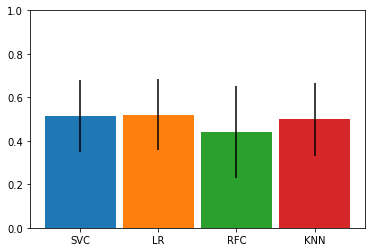

Best model: 
LR
classifier__C = 0.001
classifier__penalty = l2
dim_reduction = SelectKBest(k=20, score_func=<function ttest_ind at 0x000001B9B98DDB70>)


In [55]:
n_splits = 10
problem = "E_NE"
problem_labels = "E/no E"
pos_label = label_to_idx["E"]
idx = E_idx
X, y = mri_data, pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_E, grid_cv_svc_mri_E, grid_cv_lr_mri_E, grid_cv_rfc_mri_E, grid_cv_knn_mri_E= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [56]:
classifier_l = ["svc", "lr", "rfc", "knn"]
grid_cv_l = [grid_cv_svc_mri_E, grid_cv_lr_mri_E, grid_cv_rfc_mri_E, grid_cv_knn_mri_E]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_E, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

100it [00:02, 49.54it/s]
100it [00:01, 63.30it/s]
100it [00:39,  2.53it/s]
100it [00:04, 23.65it/s]
100it [00:01, 50.36it/s]
100it [00:01, 60.04it/s]
100it [00:38,  2.59it/s]
100it [00:04, 24.17it/s]


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=20, score_func=<function ttest_ind at 0x000001B9B98DDB70>)), ('classifier', SVC(C=1, cache_siz...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


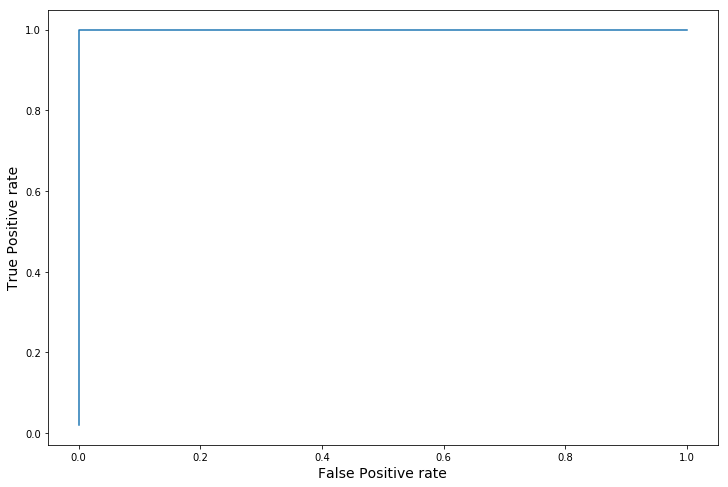

auc = 1.0


,False Positive rate (fixed),False Negative rate
0,0.10,0.0
1,0.15,0.0
2,0.20,0.0
3,0.30,0.0


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.564181,,P086
1,0.15,0.564181,,P086
2,0.20,0.564181,,P086
3,0.30,0.564181,,P086


,frequency
clustering_coefficient_Frontal_Mid_R,80
clustering_coefficient_Angular_R,79
clustering_coefficient_Cingulum_Mid_R,64
degree_centrality_Occipital_Mid_L,62
degree_centrality_Frontal_Mid_R,53
average_neighbor_degree_Precentral_R,52
clustering_coefficient_Caudate_L,48
average_neighbor_degree_Occipital_Inf_L,47
clustering_coefficient_Occipital_Mid_L,41
closeness_centrality_Parietal_Sup_L,41


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=20, score_func=<function ttest_ind at 0x000001B9B98DDB70>)), ('classifier', LogisticRegression...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


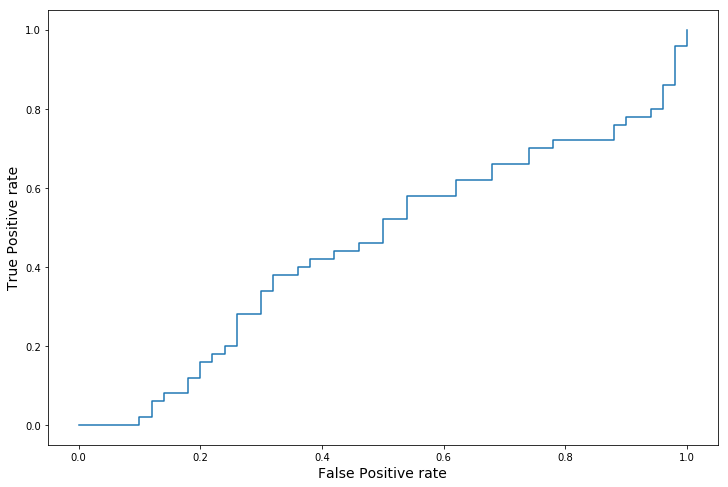

auc = 0.4548


,False Positive rate (fixed),False Negative rate
0,0.10,0.98
1,0.15,0.92
2,0.20,0.84
3,0.30,0.66


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.513659,"P014, P016, P042, P060, P066","P001, P002, P003, P006, P009, P010, P011, P015, P017, P022, P024, P025, P026, P027, P031, P032, P034, P038, P039, P040, P044, P045, P048, P049, P0..."
1,0.15,0.510216,"P014, P016, P030, P042, P047, P060, P066","P001, P002, P003, P006, P009, P010, P011, P015, P017, P022, P024, P026, P027, P031, P032, P034, P038, P039, P040, P044, P045, P048, P049, P050, P0..."
2,0.20,0.507895,"P014, P016, P030, P036, P042, P046, P047, P060, P062, P066","P001, P002, P003, P006, P009, P010, P011, P017, P022, P024, P026, P027, P031, P032, P034, P038, P039, P044, P045, P048, P049, P050, P055, P056, P0..."
3,0.30,0.503166,"P014, P016, P023, P030, P035, P036, P042, P046, P047, P060, P062, P066, P070, P071, P090","P001, P003, P006, P010, P011, P017, P022, P026, P031, P032, P034, P038, P039, P044, P045, P048, P049, P050, P055, P056, P057, P059, P064, P068, P0..."


,frequency
clustering_coefficient_Frontal_Mid_R,80
clustering_coefficient_Angular_R,79
clustering_coefficient_Cingulum_Mid_R,64
degree_centrality_Occipital_Mid_L,62
degree_centrality_Frontal_Mid_R,53
average_neighbor_degree_Precentral_R,52
clustering_coefficient_Caudate_L,48
average_neighbor_degree_Occipital_Inf_L,47
clustering_coefficient_Occipital_Mid_L,41
closeness_centrality_Parietal_Sup_L,41


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini...timators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])


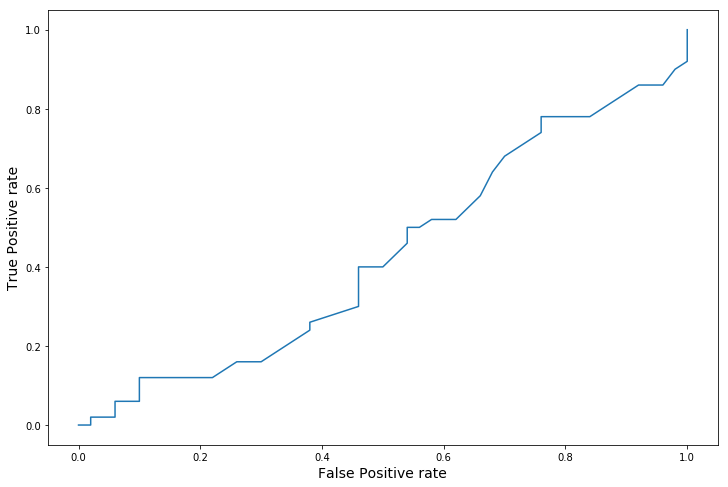

auc = 0.4304


,False Positive rate (fixed),False Negative rate
0,0.10,0.88
1,0.15,0.88
2,0.20,0.88
3,0.30,0.84


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.67,"P004, P036, P042, P090, P091","P001, P002, P003, P006, P009, P010, P011, P015, P017, P022, P025, P026, P027, P031, P034, P038, P039, P040, P045, P048, P049, P055, P056, P057, P0..."
1,0.15,0.66,"P004, P036, P042, P090, P091","P001, P002, P003, P006, P009, P010, P011, P015, P017, P022, P025, P026, P027, P031, P034, P039, P040, P045, P048, P049, P055, P056, P057, P059, P0..."
2,0.20,0.66,"P004, P036, P042, P090, P091","P001, P002, P003, P006, P009, P010, P011, P015, P017, P022, P025, P026, P027, P031, P034, P039, P040, P045, P048, P049, P055, P056, P057, P059, P0..."
3,0.30,0.62,"P004, P008, P014, P036, P042, P043, P066, P071, P082, P085, P090, P091, P107","P001, P002, P003, P006, P009, P010, P011, P015, P017, P025, P026, P027, P031, P034, P040, P045, P048, P049, P055, P056, P057, P059, P061, P064, P0..."


,frequency
eigenvector_centrality_Precuneus_L,80
eigenvector_centrality_Cuneus_L,80
degree_centrality_Parietal_Inf_R,71
eigenvector_centrality_Temporal_Mid_L,69
clustering_coefficient_Cingulum_Post_R,61
betweenness_centrality_Cingulum_Post_L,58
clustering_coefficient_Frontal_Mid_Orb_L,57
eigenvector_centrality_Thalamus_L,54
betweenness_centrality_Parietal_Inf_R,51
eigenvector_centrality_Caudate_R,50


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr...owski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform'))])


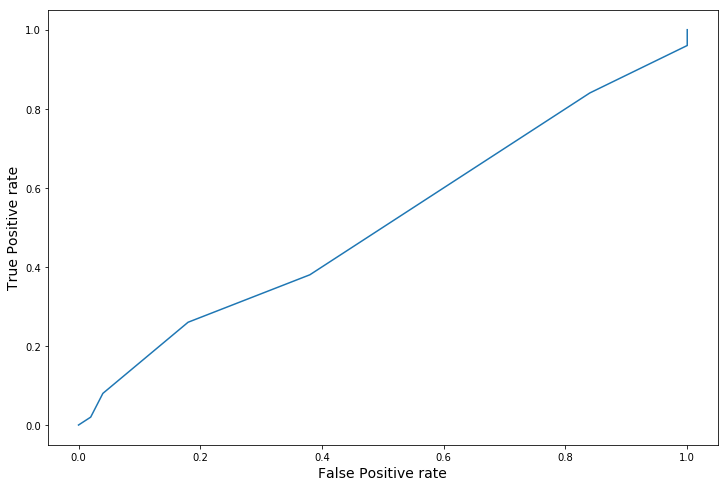

auc = 0.5136


,False Positive rate (fixed),False Negative rate
0,0.10,0.92
1,0.15,0.92
2,0.20,0.74
3,0.30,0.74


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.875,P036,"P001, P003, P006, P009, P010, P011, P015, P017, P022, P024, P025, P026, P027, P031, P032, P034, P038, P039, P040, P044, P045, P048, P049, P050, P0..."
1,0.15,0.875,P036,"P001, P003, P006, P009, P010, P011, P015, P017, P022, P024, P025, P026, P027, P031, P032, P034, P038, P039, P040, P044, P045, P048, P049, P050, P0..."
2,0.20,0.750,"P012, P036","P001, P003, P006, P009, P010, P011, P015, P017, P022, P025, P026, P027, P031, P032, P034, P038, P040, P044, P045, P048, P049, P050, P055, P056, P0..."
3,0.30,0.750,"P012, P036","P001, P003, P006, P009, P010, P011, P015, P017, P022, P025, P026, P027, P031, P032, P034, P038, P040, P044, P045, P048, P049, P050, P055, P056, P0..."


,frequency
clustering_coefficient_Frontal_Mid_Orb_L,100
clustering_coefficient_Occipital_Sup_R,100
betweenness_centrality_Parietal_Sup_L,100
clustering_coefficient_Precuneus_L,100
betweenness_centrality_0,100
betweenness_centrality_Postcentral_R,100
clustering_coefficient_Occipital_Mid_L,100
eigenvector_centrality_Frontal_Inf_Tri_L,99
eigenvector_centrality_ParaHippocampal_L,99
eigenvector_centrality_Cingulum_Post_R,98


In [57]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [58]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:10])
print("common_frequent_features: " + ", ".join(common_frequent_features))

,feature
clustering_coefficient_Frontal_Mid_R,2
clustering_coefficient_Angular_R,2
eigenvector_centrality_Frontal_Inf_Tri_L,1
eigenvector_centrality_Cuneus_L,1
eigenvector_centrality_Angular_L,1
eigenvector_centrality_ParaHippocampal_L,1
eigenvector_centrality_Precuneus_L,1
eigenvector_centrality_Temporal_Pole_Sup_R,1
eigenvector_centrality_Frontal_Med_Orb_L,1
betweenness_centrality_Heschl_R,1


common_frequent_features: 


In [59]:
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

False positives for more than 3 clsf P036
False negatives for more than 3 clsf P001, P003, P006, P009, P010, P011, P015, P017, P022, P025, P026, P027, P031, P034, P038, P039, P040, P045, P048, P049, P055, P056, P057, P059, P061, P064, P068, P072, P073, P074, P075, P076, P078, P079, P081, P083, P084, P086, P088, P092, P094, P096, P099, P105


### 3. Depression / no depression

Target distribution: 
1    50
0    50
Name: D/no D, dtype: int64 

Training SVC...
(training took 2853.2696120738983s)

Training LR...
(training took 181.25970101356506s)

Training RFC...
(training took 386.92509841918945s)

Training KNN...
(training took 1592.9881038665771s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.001, classifier__kernel = rbf","SelectKBest(k=20, score_func=<function f_classif at 0x000001B9BAA521E0>)",0.6792,0.186503
LR,"classifier__C = 0.01, classifier__penalty = l2","SelectKBest(k=20, score_func=<function f_classif at 0x000001B9BAA521E0>)",0.6848,0.188406
RFC,classifier__n_estimators = 130,"SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.6604,0.151710
KNN,"classifier__n_neighbors = 44, classifier__p = 2, classifier__weights = uniform","SelectKBest(k=20, score_func=<function f_classif at 0x000001B9BAA521E0>)",0.6944,0.181947


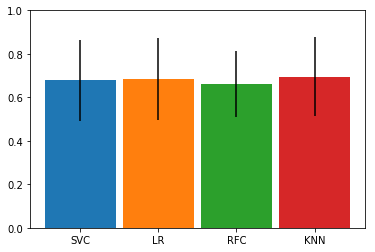

Best model: 
KNN
classifier__n_neighbors = 44
classifier__p = 2
classifier__weights = uniform
dim_reduction = SelectKBest(k=20, score_func=<function f_classif at 0x000001B9BAA521E0>)


In [45]:
n_splits = 10
problem = "D_ND"
problem_labels = "D/no D"
pos_label = label_to_idx["D"]
idx = D_idx
X, y = mri_data, pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_D, grid_cv_svc_mri_D, grid_cv_lr_mri_D, grid_cv_rfc_mri_D, grid_cv_knn_mri_D= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [46]:
grid_cv_l = [grid_cv_svc_mri_D, grid_cv_lr_mri_D, grid_cv_rfc_mri_D, grid_cv_knn_mri_D]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_D, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

100it [00:01, 67.34it/s]
100it [00:01, 72.92it/s]
100it [00:29,  3.43it/s]
100it [00:01, 77.73it/s]
100it [00:01, 70.96it/s]
100it [00:01, 82.87it/s]
100it [00:28,  3.48it/s]
100it [00:01, 84.26it/s]


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=20, score_func=<function f_classif at 0x000001B9BAA521E0>)), ('classifier', SVC(C=1, cache_siz...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


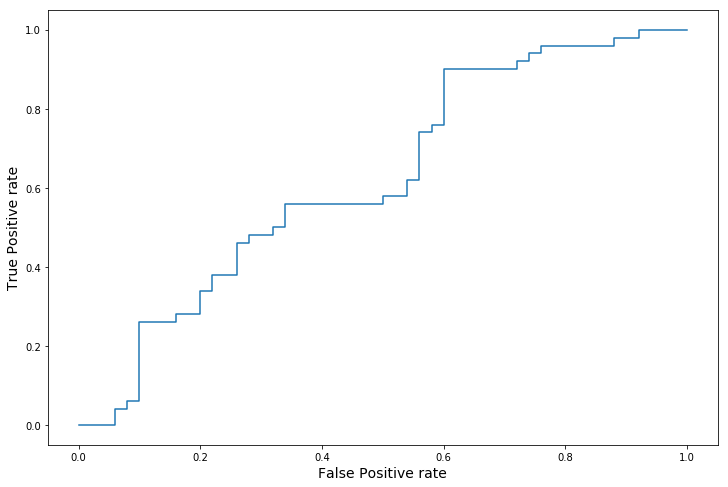

auc = 0.624


,False Positive rate (fixed),False Negative rate
0,0.10,0.74
1,0.15,0.74
2,0.20,0.66
3,0.30,0.52


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.635350,"P009, P039, P046, P047, P072","P002, P004, P012, P016, P017, P019, P020, P021, P022, P027, P028, P029, P035, P038, P040, P041, P044, P048, P049, P052, P053, P055, P057, P058, P0..."
1,0.15,0.635350,"P009, P039, P046, P047, P072","P002, P004, P012, P016, P017, P019, P020, P021, P022, P027, P028, P029, P035, P038, P040, P041, P044, P048, P049, P052, P053, P055, P057, P058, P0..."
2,0.20,0.622008,"P006, P009, P024, P032, P039, P046, P047, P062, P072, P094","P002, P004, P012, P016, P017, P019, P020, P021, P022, P028, P029, P038, P040, P041, P044, P048, P049, P052, P053, P055, P057, P058, P063, P064, P0..."
3,0.30,0.588691,"P006, P009, P024, P032, P036, P039, P046, P047, P050, P062, P072, P090, P092, P094","P004, P012, P016, P017, P019, P020, P022, P029, P038, P041, P044, P048, P049, P052, P053, P055, P057, P058, P063, P064, P065, P067, P074, P075, P0..."


,frequency
degree_centrality_Cerebelum_10_L,100
degree_centrality_Precuneus_R,100
degree_Precuneus_R,100
average_neighbor_degree_Cerebelum_9_R,100
degree_centrality_Frontal_Med_Orb_L,100
average_neighbor_degree_Cerebelum_10_L,100
clustering_coefficient_Cerebelum_9_R,100
clustering_coefficient_Cerebelum_10_L,100
degree_Frontal_Med_Orb_L,100
degree_Cerebelum_10_L,99


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=20, score_func=<function f_classif at 0x000001B9BAA521E0>)), ('classifier', LogisticRegression...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


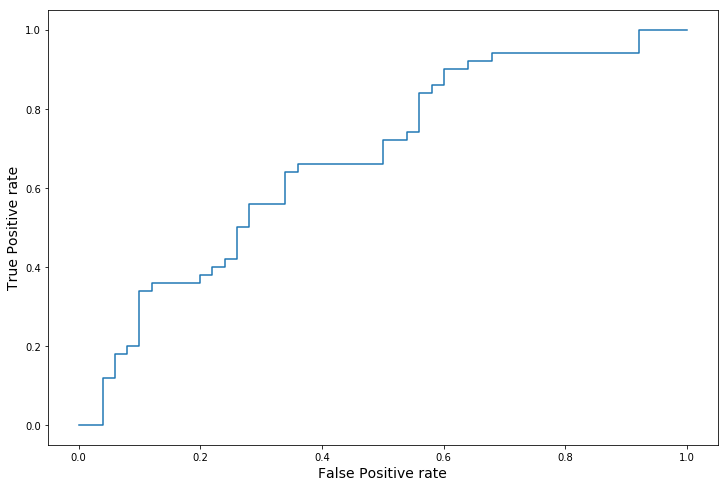

auc = 0.6744


,False Positive rate (fixed),False Negative rate
0,0.10,0.66
1,0.15,0.64
2,0.20,0.62
3,0.30,0.44


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.629920,"P009, P039, P046, P047, P072","P004, P012, P016, P017, P019, P020, P021, P022, P028, P029, P038, P040, P041, P044, P048, P049, P052, P053, P055, P057, P058, P063, P064, P065, P0..."
1,0.15,0.619558,"P009, P039, P046, P047, P072, P094","P004, P012, P016, P017, P019, P020, P021, P022, P028, P029, P038, P040, P041, P044, P048, P049, P052, P053, P055, P057, P058, P063, P064, P065, P0..."
2,0.20,0.609264,"P006, P009, P032, P039, P046, P047, P062, P072, P090, P094","P004, P012, P016, P017, P019, P020, P021, P022, P028, P029, P038, P041, P044, P048, P049, P052, P053, P055, P057, P058, P063, P064, P065, P067, P0..."
3,0.30,0.559311,"P006, P009, P024, P032, P036, P039, P046, P047, P050, P062, P072, P090, P092, P094","P004, P012, P017, P019, P020, P029, P041, P044, P048, P049, P053, P055, P057, P058, P063, P064, P065, P067, P074, P075, P096, P099, P105"


,frequency
degree_centrality_Cerebelum_10_L,100
degree_centrality_Precuneus_R,100
degree_Precuneus_R,100
average_neighbor_degree_Cerebelum_9_R,100
degree_centrality_Frontal_Med_Orb_L,100
average_neighbor_degree_Cerebelum_10_L,100
clustering_coefficient_Cerebelum_9_R,100
clustering_coefficient_Cerebelum_10_L,100
degree_Frontal_Med_Orb_L,100
degree_Cerebelum_10_L,99


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini...timators=130, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])


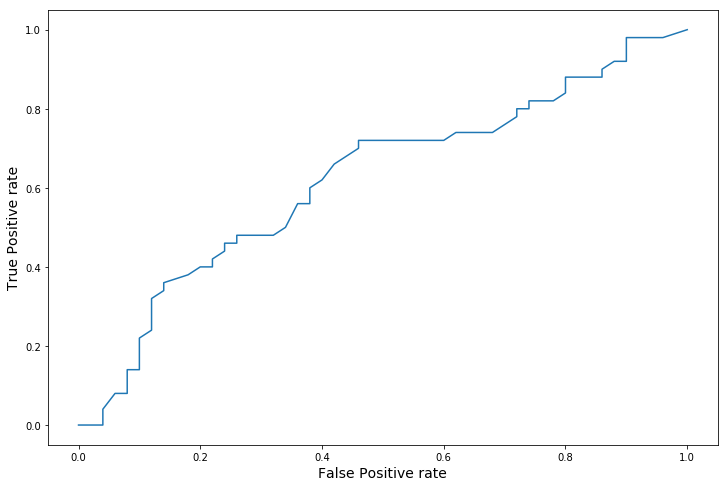

auc = 0.6212


,False Positive rate (fixed),False Negative rate
0,0.10,0.78
1,0.15,0.64
2,0.20,0.60
3,0.30,0.52


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.784615,"P039, P046, P047, P072, P091","P012, P016, P017, P019, P020, P022, P023, P025, P027, P028, P029, P030, P035, P040, P041, P044, P048, P049, P052, P053, P055, P057, P058, P060, P0..."
1,0.15,0.692308,"P024, P039, P046, P047, P072, P079, P091","P012, P016, P017, P019, P020, P023, P025, P028, P029, P030, P035, P040, P041, P049, P052, P053, P055, P057, P058, P064, P065, P066, P067, P069, P0..."
2,0.20,0.669231,"P024, P039, P046, P047, P072, P079, P081, P091, P094","P012, P016, P017, P019, P020, P023, P025, P028, P029, P030, P035, P040, P041, P049, P053, P055, P057, P058, P064, P065, P066, P069, P070, P071, P0..."
3,0.30,0.569231,"P009, P024, P036, P039, P046, P047, P056, P062, P072, P079, P081, P091, P094","P012, P016, P017, P019, P020, P023, P028, P029, P035, P040, P041, P049, P053, P055, P057, P058, P064, P065, P066, P070, P071, P074, P086, P088, P0..."


,frequency
degree_Precuneus_L,97
eigenvector_centrality_Caudate_L,93
clustering_coefficient_Putamen_R,85
clustering_coefficient_ParaHippocampal_R,73
degree_centrality_Rolandic_Oper_R,71
eigenvector_centrality_Supp_Motor_Area_L,61
betweenness_centrality_Frontal_Inf_Oper_R,56
degree_centrality_Precuneus_L,54
average_neighbor_degree_Thalamus_L,48
clustering_coefficient_Putamen_L,45


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=20, score_func=<function f_classif at 0x000001B9BAA521E0>)), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=44, p=2,
           weights='uniform'))])


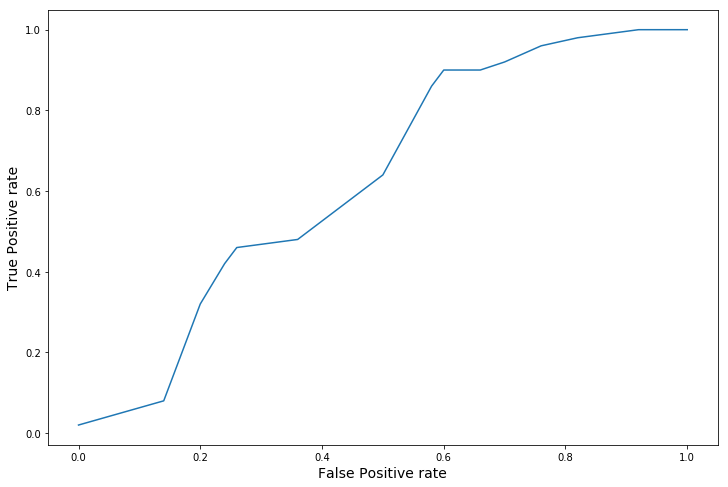

auc = 0.6296


,False Positive rate (fixed),False Negative rate
0,0.10,0.98
1,0.15,0.92
2,0.20,0.68
3,0.30,0.54


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.727273,,"P002, P004, P012, P014, P015, P016, P017, P019, P020, P021, P022, P023, P025, P027, P028, P029, P030, P035, P038, P040, P041, P042, P044, P048, P0..."
1,0.15,0.704545,,"P002, P004, P012, P014, P015, P016, P017, P019, P020, P021, P022, P023, P025, P027, P028, P029, P030, P035, P038, P040, P041, P042, P044, P048, P0..."
2,0.20,0.681818,"P009, P032, P039, P046, P047, P072, P094","P004, P012, P014, P015, P016, P017, P019, P020, P021, P022, P023, P025, P027, P028, P029, P030, P038, P040, P041, P042, P044, P048, P049, P052, P0..."
3,0.30,0.636364,"P006, P009, P032, P036, P039, P046, P047, P062, P072, P090, P092, P094","P004, P012, P016, P017, P019, P020, P021, P022, P029, P038, P041, P044, P048, P049, P052, P053, P055, P057, P058, P063, P064, P065, P067, P069, P0..."


,frequency
degree_centrality_Cerebelum_10_L,100
degree_centrality_Precuneus_R,100
degree_Precuneus_R,100
average_neighbor_degree_Cerebelum_9_R,100
degree_centrality_Frontal_Med_Orb_L,100
average_neighbor_degree_Cerebelum_10_L,100
clustering_coefficient_Cerebelum_9_R,100
clustering_coefficient_Cerebelum_10_L,100
degree_Frontal_Med_Orb_L,100
degree_Cerebelum_10_L,99


In [47]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [48]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:10])
print("common_frequent_features: " + ", ".join(common_frequent_features))

,feature
degree_Precuneus_L,4
closeness_centrality_Cerebelum_10_L,3
closeness_centrality_Cerebelum_9_R,3
degree_centrality_Precuneus_L,3
degree_Frontal_Med_Orb_L,3
average_neighbor_degree_Cerebelum_9_R,3
average_neighbor_degree_Cerebelum_10_L,3
degree_Cerebelum_10_L,3
degree_centrality_Cerebelum_9_R,3
degree_centrality_Frontal_Med_Orb_L,3


common_frequent_features: degree_Precuneus_L, closeness_centrality_Cerebelum_10_L, closeness_centrality_Cerebelum_9_R, degree_centrality_Precuneus_L, degree_Frontal_Med_Orb_L, average_neighbor_degree_Cerebelum_9_R, average_neighbor_degree_Cerebelum_10_L, degree_Cerebelum_10_L, degree_centrality_Cerebelum_9_R, degree_centrality_Frontal_Med_Orb_L, clustering_coefficient_Cerebelum_10_L, degree_Cerebelum_9_R, clustering_coefficient_Cerebelum_9_R, degree_centrality_Cerebelum_10_L, path_length_Cerebelum_10_L, degree_Precuneus_R, eigenvector_centrality_Cerebelum_10_L, degree_centrality_Precuneus_R


In [49]:
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

False positives for more than 3 clsf P006, P009, P024, P032, P036, P039, P046, P047, P062, P072, P090, P092, P094
False negatives for more than 3 clsf P004, P012, P016, P017, P019, P020, P021, P022, P027, P028, P029, P035, P038, P040, P041, P044, P048, P049, P052, P053, P055, P057, P058, P063, P064, P065, P067, P069, P070, P071, P074, P075, P087, P088, P096, P099, P105


### 4. Epilepsy / control

Target distribution: 
1    25
0    25
Name: E/C, dtype: int64 

Training SVC...
(training took 240.48438000679016s)

Training LR...
(training took 79.88734698295593s)

Training RFC...
(training took 196.8198800086975s)

Training KNN...
(training took 362.00876092910767s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.001, classifier__kernel = rbf","SelectKBest(k=20, score_func=<function ttest_ind at 0x000001B9B98DDB70>)",0.5584,0.185379
LR,"classifier__C = 0.0001, classifier__penalty = l2","SelectKBest(k=20, score_func=<function ttest_ind at 0x000001B9B98DDB70>)",0.5632,0.185531
RFC,classifier__n_estimators = 100,"SelectKBest(k=20, score_func=<function ttest_ind at 0x000001B9B98DDB70>)",0.4952,0.155155
KNN,"classifier__n_neighbors = 23, classifier__p = 1, classifier__weights = uniform","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.5424,0.165633


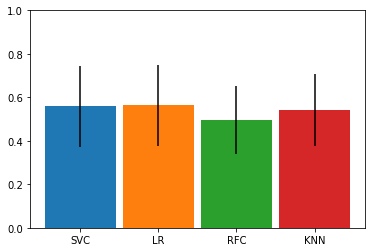

Best model: 
LR
classifier__C = 0.0001
classifier__penalty = l2
dim_reduction = SelectKBest(k=20, score_func=<function ttest_ind at 0x000001B9B98DDB70>)


In [39]:
n_splits = 5
problem = "E_C"
problem_labels = "E/C"
pos_label = label_to_idx["E"]
idx = E_C_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_E_C, grid_cv_svc_mri_E_C, grid_cv_lr_mri_E_C, grid_cv_rfc_mri_E_C, grid_cv_knn_mri_E_C= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [40]:
grid_cv_l = [grid_cv_svc_mri_E_C, grid_cv_lr_mri_E_C, grid_cv_rfc_mri_E_C, grid_cv_knn_mri_E_C]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_E_C, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

50it [00:00, 77.01it/s] 
50it [00:00, 89.36it/s]
50it [00:10,  4.67it/s]
50it [00:01, 43.41it/s]
50it [00:00, 85.55it/s]
50it [00:00, 82.19it/s]
50it [00:09,  5.45it/s]
50it [00:00, 53.96it/s]


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=20, score_func=<function ttest_ind at 0x000001B9B98DDB70>)), ('classifier', SVC(C=1, cache_siz...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


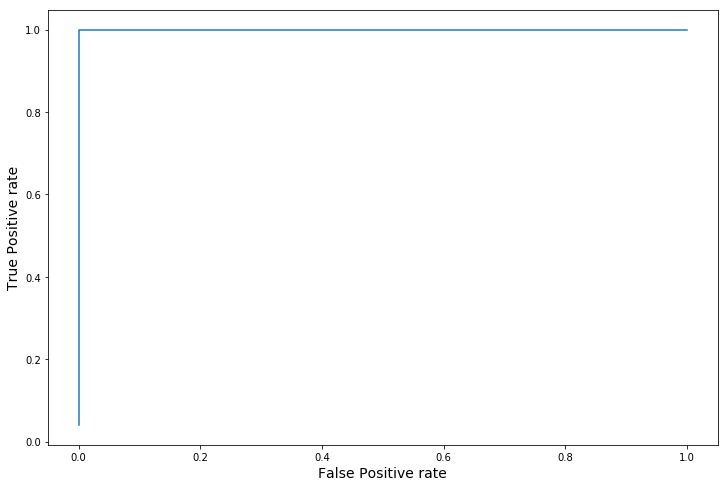

auc = 1.0


,False Positive rate (fixed),False Negative rate
0,0.10,0.0
1,0.15,0.0
2,0.20,0.0
3,0.30,0.0


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.510805,,P072
1,0.15,0.510805,,P072
2,0.20,0.510805,,P072
3,0.30,0.510805,,P072


,frequency
clustering_coefficient_Supp_Motor_Area_R,30
clustering_coefficient_Precentral_L,24
clustering_coefficient_Frontal_Inf_Tri_L,23
clustering_coefficient_Angular_L,23
clustering_coefficient_Cingulum_Post_L,23
clustering_coefficient_Paracentral_Lobule_L,21
closeness_centrality_Angular_R,20
clustering_coefficient_SupraMarginal_L,17
eigenvector_centrality_SupraMarginal_L,15
clustering_coefficient_Parietal_Sup_L,15


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=20, score_func=<function ttest_ind at 0x000001B9B98DDB70>)), ('classifier', LogisticRegression...alty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])


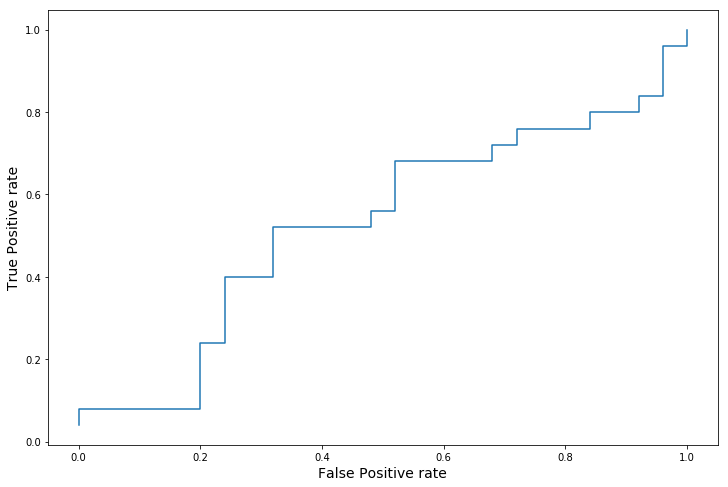

auc = 0.528


,False Positive rate (fixed),False Negative rate
0,0.10,0.92
1,0.15,0.92
2,0.20,0.76
3,0.30,0.60


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.503192,,"P001, P003, P006, P009, P010, P011, P024, P026, P031, P032, P034, P039, P045, P050, P056, P059, P068, P078, P079, P081, P083, P084, P092, P094"
1,0.15,0.503192,,"P001, P003, P006, P009, P010, P011, P024, P026, P031, P032, P034, P039, P045, P050, P056, P059, P068, P078, P079, P081, P083, P084, P092, P094"
2,0.20,0.500833,"P036, P046, P047, P062, P089","P001, P003, P006, P010, P011, P026, P031, P032, P034, P039, P045, P050, P056, P059, P068, P078, P079, P081, P083, P084"
3,0.30,0.500338,"P036, P046, P047, P062, P089, P090","P001, P003, P010, P011, P026, P031, P034, P045, P050, P056, P059, P078, P079, P081, P083, P084"


,frequency
clustering_coefficient_Supp_Motor_Area_R,30
clustering_coefficient_Precentral_L,24
clustering_coefficient_Frontal_Inf_Tri_L,23
clustering_coefficient_Angular_L,23
clustering_coefficient_Cingulum_Post_L,23
clustering_coefficient_Paracentral_Lobule_L,21
closeness_centrality_Angular_R,20
clustering_coefficient_SupraMarginal_L,17
eigenvector_centrality_SupraMarginal_L,15
clustering_coefficient_Parietal_Sup_L,15


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=20, score_func=<function ttest_ind at 0x000001B9B98DDB70>)), ('classifier', RandomForestClassi...timators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])


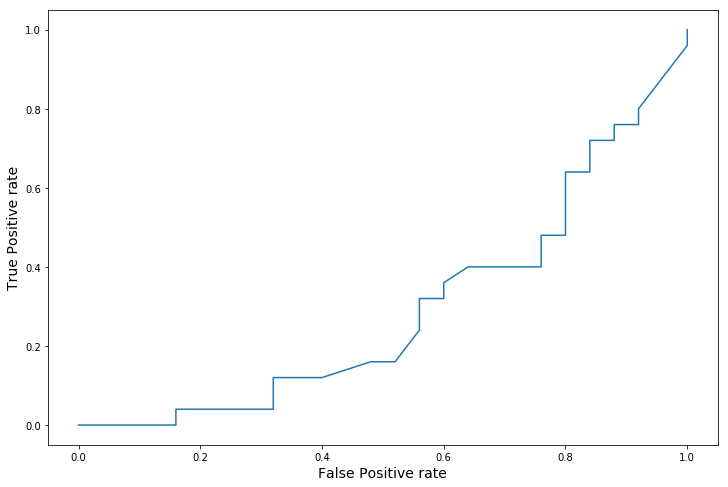

auc = 0.292


,False Positive rate (fixed),False Negative rate
0,0.10,1.00
1,0.15,1.00
2,0.20,0.96
3,0.30,0.96


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.77,P046,"P001, P003, P006, P009, P010, P011, P024, P026, P031, P032, P034, P039, P045, P050, P056, P059, P068, P072, P078, P079, P081, P083, P084, P092, P094"
1,0.15,0.77,P046,"P001, P003, P006, P009, P010, P011, P024, P026, P031, P032, P034, P039, P045, P050, P056, P059, P068, P072, P078, P079, P081, P083, P084, P092, P094"
2,0.20,0.71,"P036, P046, P051, P062","P001, P003, P006, P009, P010, P011, P024, P026, P031, P032, P034, P039, P045, P050, P056, P059, P068, P072, P078, P079, P081, P083, P084, P092, P094"
3,0.30,0.71,"P036, P046, P051, P062","P001, P003, P006, P009, P010, P011, P024, P026, P031, P032, P034, P039, P045, P050, P056, P059, P068, P072, P078, P079, P081, P083, P084, P092, P094"


,frequency
clustering_coefficient_Supp_Motor_Area_R,30
clustering_coefficient_Precentral_L,24
clustering_coefficient_Frontal_Inf_Tri_L,23
clustering_coefficient_Angular_L,23
clustering_coefficient_Cingulum_Post_L,23
clustering_coefficient_Paracentral_Lobule_L,21
closeness_centrality_Angular_R,20
clustering_coefficient_SupraMarginal_L,17
eigenvector_centrality_SupraMarginal_L,15
clustering_coefficient_Parietal_Sup_L,15


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr...wski',
           metric_params=None, n_jobs=1, n_neighbors=23, p=1,
           weights='uniform'))])


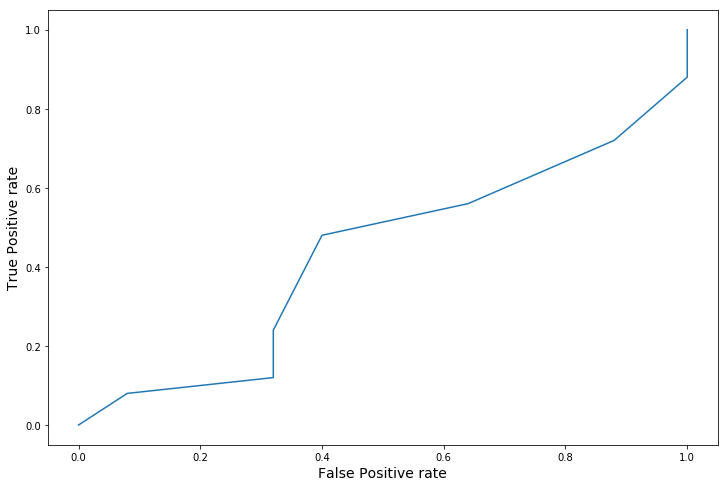

auc = 0.43039999999999995


,False Positive rate (fixed),False Negative rate
0,0.10,0.92
1,0.15,0.92
2,0.20,0.92
3,0.30,0.92


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.652174,,"P001, P003, P006, P009, P010, P011, P024, P026, P031, P032, P034, P039, P045, P050, P056, P059, P068, P072, P078, P079, P081, P083, P084, P092, P094"
1,0.15,0.652174,,"P001, P003, P006, P009, P010, P011, P024, P026, P031, P032, P034, P039, P045, P050, P056, P059, P068, P072, P078, P079, P081, P083, P084, P092, P094"
2,0.20,0.652174,,"P001, P003, P006, P009, P010, P011, P024, P026, P031, P032, P034, P039, P045, P050, P056, P059, P068, P072, P078, P079, P081, P083, P084, P092, P094"
3,0.30,0.652174,,"P001, P003, P006, P009, P010, P011, P024, P026, P031, P032, P034, P039, P045, P050, P056, P059, P068, P072, P078, P079, P081, P083, P084, P092, P094"


,frequency
betweenness_centrality_Temporal_Sup_R,50
betweenness_centrality_Frontal_Sup_Medial_R,50
eigenvector_centrality_ParaHippocampal_L,50
eigenvector_centrality_Cingulum_Mid_R,50
betweenness_centrality_SupraMarginal_R,49
betweenness_centrality_Frontal_Med_Orb_L,49
eigenvector_centrality_Hippocampus_R,49
eigenvector_centrality_Cingulum_Mid_L,49
betweenness_centrality_Frontal_Sup_R,49
clustering_coefficient_Frontal_Mid_Orb_L,48


In [41]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [42]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:10])
print("common_frequent_features: " + ", ".join(common_frequent_features))

,feature
degree_centrality_Cingulum_Mid_R,1
betweenness_centrality_Temporal_Sup_R,1
eigenvector_centrality_Cingulum_Mid_R,1
eigenvector_centrality_ParaHippocampal_L,1
eigenvector_centrality_Occipital_Sup_R,1
betweenness_centrality_0,1
betweenness_centrality_Olfactory_L,1
clustering_coefficient_Occipital_Sup_R,1
clustering_coefficient_ParaHippocampal_L,1
eigenvector_centrality_Hippocampus_R,1


common_frequent_features: 


In [43]:
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

False positives for more than 3 clsf 
False negatives for more than 3 clsf P001, P003, P006, P009, P010, P011, P024, P026, P031, P032, P034, P039, P045, P050, P056, P059, P068, P072, P078, P079, P081, P083, P084, P092, P094


### 5. Depression / control

Target distribution: 
1    25
0    25
Name: D/C, dtype: int64 

Training SVC...
(training took 192.36747694015503s)

Training LR...
(training took 60.665738344192505s)

Training RFC...
(training took 131.86231017112732s)

Training KNN...
(training took 345.3414318561554s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.01, classifier__kernel = rbf","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.7696,0.145010
LR,"classifier__C = 0.01, classifier__penalty = l2","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.7616,0.153667
RFC,classifier__n_estimators = 100,"SelectKBest(k=20, score_func=<function f_classif at 0x000001B9BAA521E0>)",0.7432,0.148128
KNN,"classifier__n_neighbors = 20, classifier__p = 2, classifier__weights = distance","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.7680,0.136704


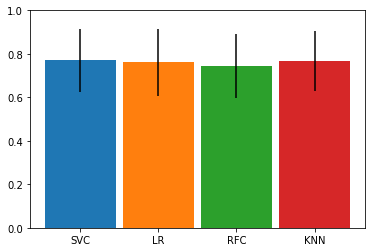

Best model: 
SVC
classifier__C = 1
classifier__gamma = 0.01
classifier__kernel = rbf
dim_reduction = SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             n_selected=20, prefit=False)


In [35]:
n_splits = 5
problem = "D_C"
problem_labels = "D/C"
pos_label = label_to_idx["D"]
idx = D_C_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_D_C, grid_cv_svc_mri_D_C, grid_cv_lr_mri_D_C, grid_cv_rfc_mri_D_C, grid_cv_knn_mri_D_C = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [36]:
grid_cv_l = [grid_cv_svc_mri_D_C, grid_cv_lr_mri_D_C, grid_cv_rfc_mri_D_C, grid_cv_knn_mri_D_C ]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_D_C, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

50it [00:00, 68.68it/s]
50it [00:00, 59.54it/s]
50it [00:07,  7.06it/s]
50it [00:00, 66.67it/s]
50it [00:00, 56.58it/s]
50it [00:00, 59.89it/s]
50it [00:08,  5.72it/s]
50it [00:00, 53.91it/s]


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


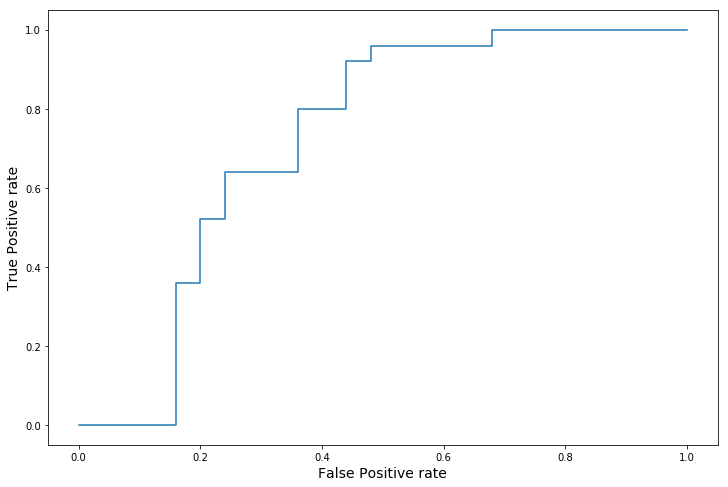

auc = 0.7247999999999999


,False Positive rate (fixed),False Negative rate
0,0.10,1.00
1,0.15,1.00
2,0.20,0.48
3,0.30,0.36


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.969623,,"P004, P012, P014, P016, P019, P020, P021, P023, P028, P029, P030, P035, P041, P042, P052, P053, P058, P060, P063, P065, P066, P067, P069, P070, P071"
1,0.15,0.969623,,"P004, P012, P014, P016, P019, P020, P021, P023, P028, P029, P030, P035, P041, P042, P052, P053, P058, P060, P063, P065, P066, P067, P069, P070, P071"
2,0.20,0.629353,"P036, P046, P047, P062, P090","P004, P012, P016, P019, P020, P028, P029, P052, P053, P058, P063, P065, P067"
3,0.30,0.540068,"P036, P046, P047, P062, P090, P098","P012, P016, P019, P020, P029, P052, P058, P063, P065, P067"


,frequency
betweenness_centrality_Frontal_Med_Orb_L,50
eigenvector_centrality_Occipital_Sup_R,50
betweenness_centrality_Occipital_Sup_R,50
degree_centrality_Caudate_L,50
eigenvector_centrality_Caudate_L,50
betweenness_centrality_Caudate_L,50
degree_Caudate_L,50
clustering_coefficient_Parietal_Inf_L,50
degree_Occipital_Sup_R,49
betweenness_centrality_Temporal_Pole_Sup_L,48


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


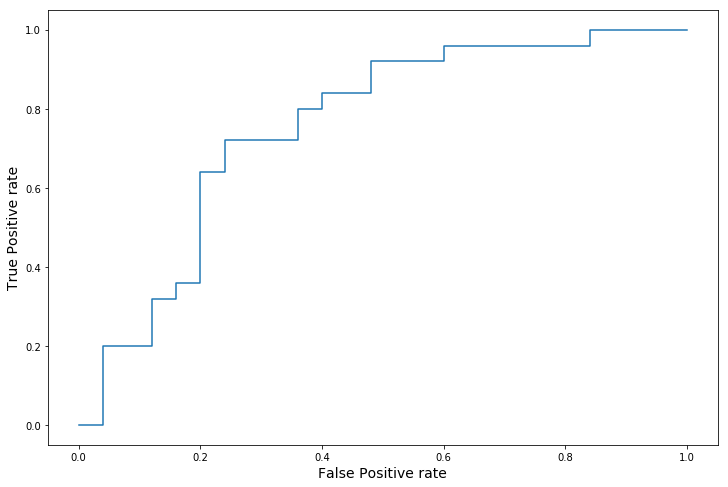

auc = 0.7552


,False Positive rate (fixed),False Negative rate
0,0.10,0.80
1,0.15,0.68
2,0.20,0.36
3,0.30,0.28


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.647655,P047,"P004, P012, P016, P019, P020, P021, P023, P028, P029, P030, P035, P041, P052, P053, P058, P063, P065, P067, P069, P070, P071"
1,0.15,0.603757,"P046, P047, P062","P004, P012, P016, P019, P020, P021, P028, P029, P041, P052, P053, P058, P063, P065, P067, P069, P070, P071"
2,0.20,0.500711,"P036, P046, P047, P062, P090","P004, P012, P019, P020, P029, P052, P058, P063, P065, P067"
3,0.30,0.452213,"P036, P046, P047, P062, P090, P098","P012, P019, P020, P029, P058, P063, P065, P067"


,frequency
betweenness_centrality_Frontal_Med_Orb_L,50
eigenvector_centrality_Occipital_Sup_R,50
betweenness_centrality_Occipital_Sup_R,50
degree_centrality_Caudate_L,50
eigenvector_centrality_Caudate_L,50
betweenness_centrality_Caudate_L,50
degree_Caudate_L,50
clustering_coefficient_Parietal_Inf_L,50
degree_Occipital_Sup_R,49
betweenness_centrality_Temporal_Pole_Sup_L,48


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=20, score_func=<function f_classif at 0x000001B9BAA521E0>)), ('classifier', RandomForestClassi...timators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])


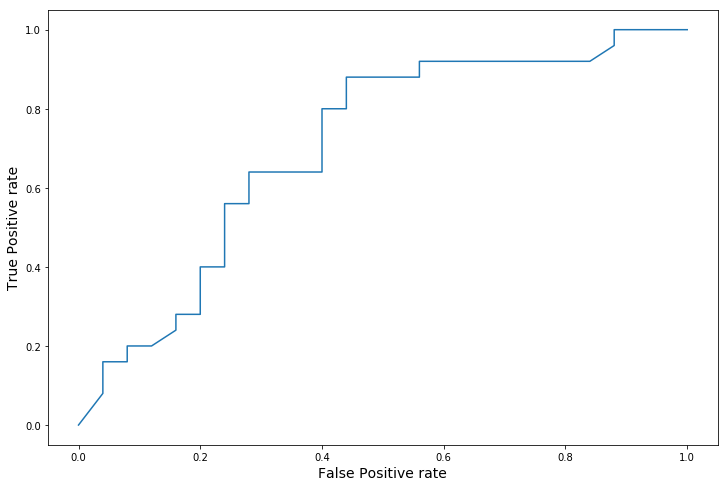

auc = 0.7040000000000001


,False Positive rate (fixed),False Negative rate
0,0.10,0.80
1,0.15,0.80
2,0.20,0.60
3,0.30,0.36


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.86,"P047, P091","P004, P012, P014, P016, P019, P020, P023, P028, P029, P030, P035, P041, P052, P053, P058, P063, P065, P067, P069, P070, P071"
1,0.15,0.84,"P047, P091","P004, P012, P014, P016, P019, P020, P023, P028, P029, P030, P035, P041, P052, P053, P058, P063, P065, P067, P070, P071"
2,0.20,0.74,"P036, P046, P047, P090, P091","P004, P012, P019, P020, P023, P028, P029, P030, P035, P052, P053, P058, P063, P065, P067, P070, P071"
3,0.30,0.51,"P036, P046, P047, P062, P090, P091, P107","P012, P020, P028, P029, P052, P053, P058, P063, P065, P067"


,frequency
degree_centrality_Occipital_Sup_R,50
betweenness_centrality_Frontal_Med_Orb_L,50
degree_centrality_Frontal_Med_Orb_L,50
eigenvector_centrality_Caudate_L,50
degree_Occipital_Sup_R,50
degree_Frontal_Med_Orb_L,50
path_length_Cerebelum_10_L,46
path_length_Cerebelum_9_R,46
clustering_coefficient_Cerebelum_9_R,42
average_neighbor_degree_Cerebelum_9_R,41


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr...ski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='distance'))])


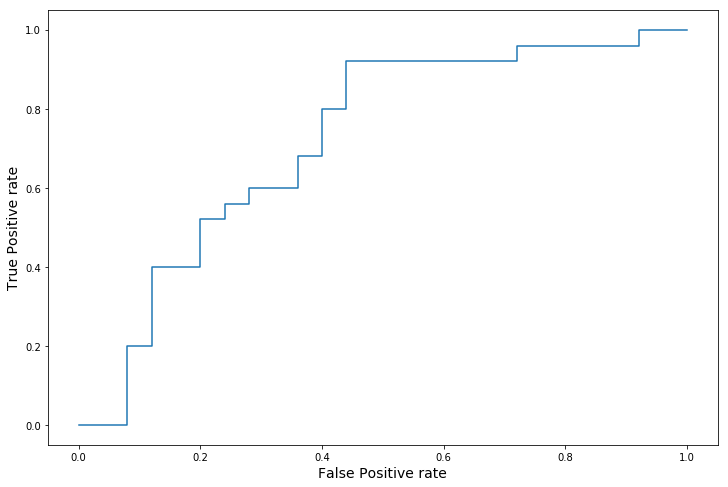

auc = 0.7200000000000001


,False Positive rate (fixed),False Negative rate
0,0.10,0.80
1,0.15,0.60
2,0.20,0.48
3,0.30,0.40


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.654051,"P036, P047","P012, P016, P019, P020, P021, P028, P029, P030, P035, P041, P052, P053, P058, P060, P063, P065, P066, P067, P069, P070, P071"
1,0.15,0.627071,"P036, P047, P062","P012, P016, P019, P020, P029, P030, P035, P041, P052, P053, P058, P063, P065, P067, P069, P071"
2,0.20,0.574373,"P036, P046, P047, P062, P090","P012, P016, P019, P020, P029, P030, P052, P053, P058, P065, P067, P069, P071"
3,0.30,0.510380,"P036, P046, P047, P062, P090, P091, P098","P012, P016, P019, P020, P029, P052, P053, P058, P065, P067, P069"


,frequency
betweenness_centrality_Frontal_Med_Orb_L,50
eigenvector_centrality_Occipital_Sup_R,50
betweenness_centrality_Occipital_Sup_R,50
degree_centrality_Caudate_L,50
eigenvector_centrality_Caudate_L,50
betweenness_centrality_Caudate_L,50
degree_Caudate_L,50
clustering_coefficient_Parietal_Inf_L,50
degree_Occipital_Sup_R,49
betweenness_centrality_Temporal_Pole_Sup_L,48


In [37]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [44]:
freq_list=all_features[all_features['frequency_norm']>=0.1]
freq_list=freq_list.reset_index()
freq_list['feature_pure']=''
freq_list['feature_score']=''
appendix_list_thick=['_NumVert','_GrayVol','_FoldInd','_CurvInd','_GausCurv','_ThickStd','_ThickAvg','_MeanCurv','_SurfArea']
appendix_list_vol=['_Volume_mm3','_normMean','_normMin','_normMax','_normStdDev','_normRange','_NVoxels']
for i in range(len(freq_list)):
    for j in appendix_list_thick:
        if j in freq_list['feature'].loc[i]:
            freq_list['feature_pure'].loc[i]=freq_list['feature'].loc[i].replace(j, '')
            freq_list['feature_score'].loc[i]=freq_list['frequency_norm'].loc[i]/9
    for k in appendix_list_vol:
        if k in freq_list['feature'].loc[i]:
            freq_list['feature_pure'].loc[i]=freq_list['feature'].loc[i].replace(k, '')
            freq_list['feature_score'].loc[i]=freq_list['frequency_norm'].loc[i]/7

freq_pure_list=freq_list[['feature_pure','feature_score']].groupby(['feature_pure']).sum()
freq_pure_list=freq_pure_list.sort_values(['feature_score'], ascending=False)
freq_pure_list[freq_pure_list['feature_score']>=freq_pure_list['feature_score'].max()*0.5]

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7,file_frequent="T1_sMRI_{}_frequent_{}.csv".format(problem, clf))
display(frequent_features.iloc[:10])
print("common_frequent_features: " + ", ".join(common_frequent_features))
get_frequent_regions(all_features)

In [ ]:
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

### 6. Epilepsy with depression / only epilepsy

Target distribution: 
1    25
0    25
Name: DE/E, dtype: int64 

Training SVC...
(training took 130.56794500350952s)

Training LR...
(training took 40.90958023071289s)

Training RFC...
(training took 100.50817275047302s)

Training KNN...
(training took 189.04137420654297s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.01, classifier__kernel = rbf","SelectKBest(k=20, score_func=<function ttest_ind at 0x000001B9B98DDB70>)",0.6576,0.173834
LR,"classifier__C = 0.0001, classifier__penalty = l2","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.6464,0.129333
RFC,classifier__n_estimators = 190,"SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.6912,0.135538
KNN,"classifier__n_neighbors = 20, classifier__p = 2, classifier__weights = uniform","SelectKBest(k=20, score_func=<function ttest_ind at 0x000001B9B98DDB70>)",0.6616,0.134928


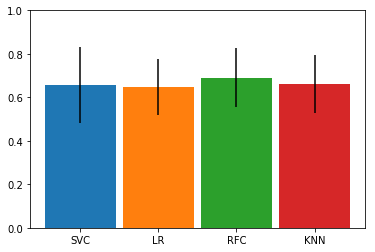

Best model: 
RFC
classifier__n_estimators = 190
dim_reduction = SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
             n_selected=20, prefit=False)


In [50]:
n_splits = 5
problem = "DE_E"
problem_labels = "DE/E"
pos_label = label_to_idx["DE"]
idx = DE_E_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_DE_E, grid_cv_svc_mri_DE_E, grid_cv_lr_mri_DE_E, grid_cv_rfc_mri_DE_E, grid_cv_knn_mri_DE_E = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [51]:
grid_cv_l = [grid_cv_svc_mri_DE_E, grid_cv_lr_mri_DE_E, grid_cv_rfc_mri_DE_E, grid_cv_knn_mri_DE_E  ]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_DE_E, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

50it [00:00, 156.17it/s]
50it [00:06,  7.90it/s]
50it [00:15,  3.30it/s]
50it [00:00, 151.01it/s]
50it [00:00, 144.06it/s]
50it [00:06,  8.20it/s]
50it [00:14,  3.34it/s]
50it [00:00, 145.32it/s]


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=20, score_func=<function ttest_ind at 0x000001B9B98DDB70>)), ('classifier', SVC(C=1, cache_siz...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


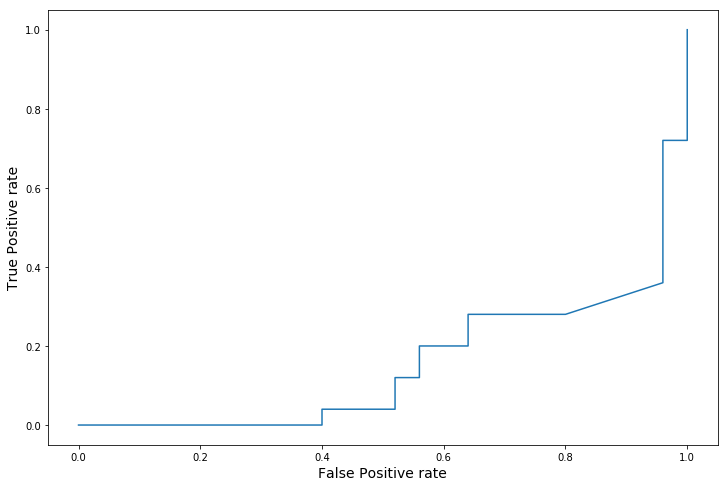

auc = 0.1504


,False Positive rate (fixed),False Negative rate
0,0.10,1.0
1,0.15,1.0
2,0.20,1.0
3,0.30,1.0


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.729245,,"P002, P015, P017, P022, P025, P027, P038, P040, P044, P048, P049, P055, P057, P061, P064, P073, P074, P075, P076, P086, P087, P088, P096, P099, P105"
1,0.15,0.729245,,"P002, P015, P017, P022, P025, P027, P038, P040, P044, P048, P049, P055, P057, P061, P064, P073, P074, P075, P076, P086, P087, P088, P096, P099, P105"
2,0.20,0.729245,,"P002, P015, P017, P022, P025, P027, P038, P040, P044, P048, P049, P055, P057, P061, P064, P073, P074, P075, P076, P086, P087, P088, P096, P099, P105"
3,0.30,0.729245,,"P002, P015, P017, P022, P025, P027, P038, P040, P044, P048, P049, P055, P057, P061, P064, P073, P074, P075, P076, P086, P087, P088, P096, P099, P105"


,frequency
clustering_coefficient_Paracentral_Lobule_L,32
clustering_coefficient_Frontal_Sup_Medial_R,31
clustering_coefficient_Occipital_Sup_R,29
clustering_coefficient_Precuneus_R,28
clustering_coefficient_Parietal_Inf_R,28
clustering_coefficient_Precentral_R,25
clustering_coefficient_Occipital_Inf_L,23
clustering_coefficient_Frontal_Sup_L,21
clustering_coefficient_Frontal_Sup_R,20
eigenvector_centrality_Occipital_Sup_R,19


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini...alty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])


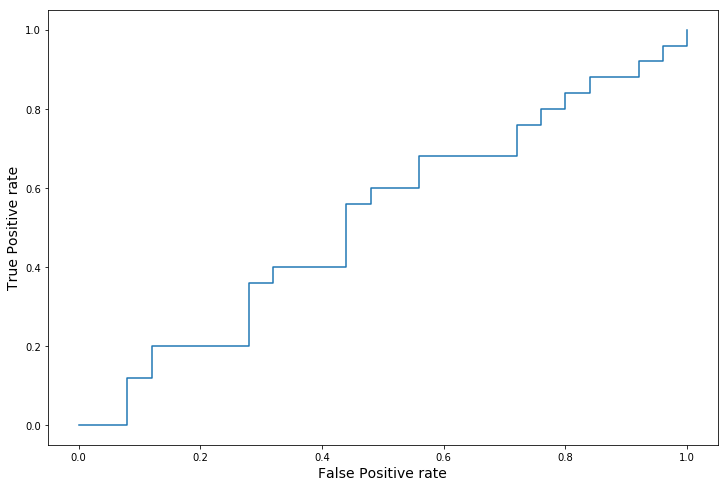

auc = 0.52


,False Positive rate (fixed),False Negative rate
0,0.10,0.88
1,0.15,0.80
2,0.20,0.80
3,0.30,0.64


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.502187,"P009, P072","P002, P017, P022, P027, P038, P040, P044, P048, P049, P055, P057, P061, P064, P073, P074, P075, P076, P086, P087, P088, P096, P099, P105"
1,0.15,0.501708,"P009, P072, P094","P002, P017, P022, P027, P038, P040, P044, P048, P049, P055, P057, P064, P073, P074, P075, P086, P087, P088, P096, P099, P105"
2,0.20,0.501708,"P009, P072, P094","P002, P017, P022, P027, P038, P040, P044, P048, P049, P055, P057, P064, P073, P074, P075, P086, P087, P088, P096, P099, P105"
3,0.30,0.500458,"P009, P024, P032, P039, P072, P092, P094","P002, P017, P022, P038, P044, P048, P049, P055, P057, P064, P074, P075, P087, P088, P096, P099, P105"


,frequency
clustering_coefficient_ParaHippocampal_L,50
clustering_coefficient_Hippocampus_R,49
clustering_coefficient_Occipital_Inf_R,49
betweenness_centrality_Frontal_Inf_Oper_R,45
clustering_coefficient_Occipital_Mid_R,35
clustering_coefficient_Insula_R,34
clustering_coefficient_Putamen_R,33
clustering_coefficient_SupraMarginal_L,32
clustering_coefficient_Cerebelum_4_5_L,30
clustering_coefficient_Occipital_Mid_L,27


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini...timators=190, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])


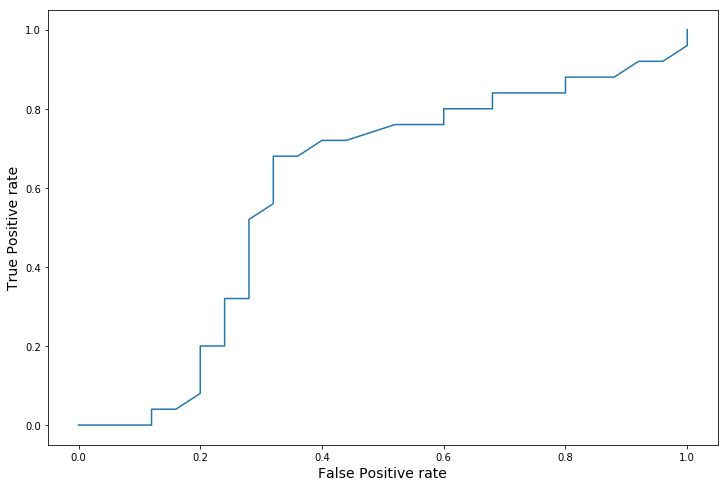

auc = 0.5960000000000001


,False Positive rate (fixed),False Negative rate
0,0.10,1.00
1,0.15,0.96
2,0.20,0.80
3,0.30,0.48


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.873684,,"P002, P015, P017, P022, P025, P027, P038, P040, P044, P048, P049, P055, P057, P061, P064, P073, P074, P075, P076, P086, P087, P088, P096, P099, P105"
1,0.15,0.800000,"P009, P072, P094","P002, P015, P017, P022, P025, P027, P038, P040, P044, P048, P049, P055, P057, P061, P064, P073, P074, P075, P076, P086, P087, P088, P096, P099, P105"
2,0.20,0.736842,"P009, P072, P079, P081, P094","P015, P017, P025, P027, P040, P048, P049, P055, P057, P061, P064, P073, P074, P075, P076, P086, P087, P088, P096, P099, P105"
3,0.30,0.552632,"P001, P009, P039, P072, P079, P081, P094","P017, P040, P048, P049, P055, P057, P064, P075, P076, P087, P088, P099, P105"


,frequency
clustering_coefficient_ParaHippocampal_L,50
clustering_coefficient_Hippocampus_R,49
clustering_coefficient_Occipital_Inf_R,49
betweenness_centrality_Frontal_Inf_Oper_R,45
clustering_coefficient_Occipital_Mid_R,35
clustering_coefficient_Insula_R,34
clustering_coefficient_Putamen_R,33
clustering_coefficient_SupraMarginal_L,32
clustering_coefficient_Cerebelum_4_5_L,30
clustering_coefficient_Occipital_Mid_L,27


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=20, score_func=<function ttest_ind at 0x000001B9B98DDB70>)), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform'))])


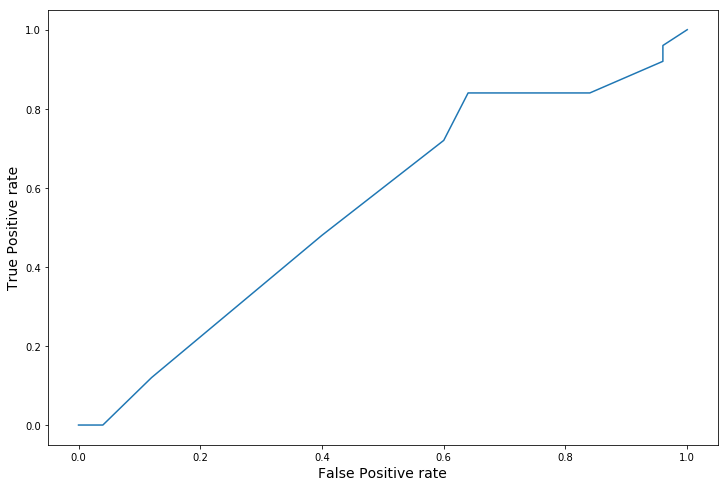

auc = 0.5528


,False Positive rate (fixed),False Negative rate
0,0.10,1.00
1,0.15,0.88
2,0.20,0.88
3,0.30,0.88


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.65,,"P002, P015, P017, P022, P025, P027, P038, P040, P044, P048, P049, P055, P057, P061, P064, P073, P074, P075, P076, P086, P087, P088, P096, P099, P105"
1,0.15,0.60,P079,"P002, P015, P017, P022, P025, P027, P038, P040, P044, P048, P049, P055, P057, P061, P064, P073, P074, P075, P076, P086, P087, P088, P096, P099, P105"
2,0.20,0.60,P079,"P002, P015, P017, P022, P025, P027, P038, P040, P044, P048, P049, P055, P057, P061, P064, P073, P074, P075, P076, P086, P087, P088, P096, P099, P105"
3,0.30,0.60,P079,"P002, P015, P017, P022, P025, P027, P038, P040, P044, P048, P049, P055, P057, P061, P064, P073, P074, P075, P076, P086, P087, P088, P096, P099, P105"


,frequency
clustering_coefficient_Paracentral_Lobule_L,32
clustering_coefficient_Frontal_Sup_Medial_R,31
clustering_coefficient_Occipital_Sup_R,29
clustering_coefficient_Precuneus_R,28
clustering_coefficient_Parietal_Inf_R,28
clustering_coefficient_Precentral_R,25
clustering_coefficient_Occipital_Inf_L,23
clustering_coefficient_Frontal_Sup_L,21
clustering_coefficient_Frontal_Sup_R,20
eigenvector_centrality_Occipital_Sup_R,19


In [52]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [53]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:10])
print("common_frequent_features: " + ", ".join(common_frequent_features))

,feature
clustering_coefficient_Occipital_Inf_R,2
betweenness_centrality_Frontal_Inf_Oper_R,2
clustering_coefficient_ParaHippocampal_L,2
clustering_coefficient_Hippocampus_R,2


common_frequent_features: 


In [54]:
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

False positives for more than 3 clsf 
False negatives for more than 3 clsf P002, P015, P017, P022, P025, P027, P038, P040, P044, P048, P049, P055, P057, P061, P064, P073, P074, P075, P076, P086, P087, P088, P096, P099, P105


In [ ]:
mri_data1=mri_data[['Right-Cerebellum-White-Matter_normMean', 'Right-Thalamus-Proper_normMean', 'Left-Accumbens-area_normMax', 'lateraloccipital_GausCurv_l', 'postcentral_ThickAvg_l', 'lingual_GausCurv_r', 'superiorfrontal_MeanCurv_l', 'CC_Mid_Posterior_normMean', 'isthmuscingulate_ThickAvg_l', 'Right-Pallidum_normMean', 'lateraloccipital_GausCurv_r', 'entorhinal_ThickAvg_l', 'isthmuscingulate_MeanCurv_l', 'CC_Anterior_normMean', 'Right-Thalamus-Proper_normMax', 'bankssts_ThickAvg_l', 'cuneus_ThickAvg_l', 'inferiortemporal_MeanCurv_r', 'caudalanteriorcingulate_ThickAvg_l', 'Left-Putamen_normMax', 'supramarginal_MeanCurv_r', 'inferiortemporal_ThickAvg_l', 'lateraloccipital_MeanCurv_r']]

In [ ]:
n_splits = 5
problem = "DE_E"
problem_labels = "DE/E"
pos_label = label_to_idx["DE"]
idx = DE_E_idx
X, y = mri_data1[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_DE_E, grid_cv_svc_mri_DE_E, grid_cv_lr_mri_DE_E, grid_cv_rfc_mri_DE_E, grid_cv_knn_mri_DE_E = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

### 6.2. Epilepsy with depression / only depression

In [ ]:
n_splits = 5
problem = "DE_D"
problem_labels = "DE/D"
pos_label = label_to_idx["DE"]
idx = DE_D_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_DE_D, grid_cv_svc_mri_DE_D, grid_cv_lr_mri_DE_D, grid_cv_rfc_mri_DE_D, grid_cv_knn_mri_DE_D= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [ ]:
grid_cv_l = [grid_cv_svc_mri_DE_D, grid_cv_lr_mri_DE_D, grid_cv_rfc_mri_DE_D, grid_cv_knn_mri_DE_D]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_DE_D, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

In [ ]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [ ]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:10])
print("common_frequent_features: " + ", ".join(common_frequent_features))

In [ ]:
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

### 7. TLE / no epilepsy

In [ ]:
n_splits = 5
problem = "TLE_noE"
problem_labels = "TLE/no E"
pos_label = label_to_idx["TLE"]
idx = TLE_noE_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_TLE_noE, grid_cv_svc_mri_TLE_noE, grid_cv_lr_mri_TLE_noE, grid_cv_rfc_mri_TLE_noE, grid_cv_knn_mri_TLE_noE= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [ ]:
grid_cv_l = [ grid_cv_svc_mri_TLE_noE, grid_cv_lr_mri_TLE_noE, grid_cv_rfc_mri_TLE_noE, grid_cv_knn_mri_TLE_noE]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_TLE_noE, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

In [ ]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [ ]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:10])
print("common_frequent_features: " + ", ".join(common_frequent_features))

In [ ]:
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

### 8. TLE / control

In [ ]:
n_splits = 5
problem = "TLE_С"
problem_labels = "TLE/C"
pos_label = label_to_idx["TLE"]
idx = TLE_C_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_TLE_C, grid_cv_svc_mri_TLE_C, grid_cv_lr_mri_TLE_C, grid_cv_rfc_mri_TLE_C, grid_cv_knn_mri_TLE_C= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [ ]:
grid_cv_l = [grid_cv_svc_mri_TLE_C, grid_cv_lr_mri_TLE_C, grid_cv_rfc_mri_TLE_C, grid_cv_knn_mri_TLE_C]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_TLE_C, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

In [ ]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [ ]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:30])
print("common_frequent_features: " + ", ".join(common_frequent_features))

In [ ]:
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

### 9. MRI positive / MRI negative

In [ ]:
mri_data

In [ ]:
n_splits = 5
problem = "Pos_Neg"
problem_labels = "MRIPositive/Negative "
pos_label = label_to_idx["Positive"]
idx = Pos_Neg_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_Pos_Neg, grid_cv_svc_mri_Pos_Neg, grid_cv_lr_mri_Pos_Neg, grid_cv_rfc_mri_Pos_Neg, grid_cv_knn_mri_Pos_Neg = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=-1)

In [ ]:
grid_cv_l = [grid_cv_svc_mri_Pos_Neg, grid_cv_lr_mri_Pos_Neg, grid_cv_rfc_mri_Pos_Neg, grid_cv_knn_mri_Pos_Neg]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_Pos_Neg, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

In [ ]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [ ]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:30])
print("common_frequent_features: " + ", ".join(common_frequent_features))

In [ ]:
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

In [ ]:
#without LLE and PCA
n_splits = 5
X, y = mri_data[Pos_Neg_idx], labels[Pos_Neg_idx]["MRIPositive/Negative "]

best_model_mri_Pos_Neg, grid_cv_svc_mri_Pos_Neg, grid_cv_lr_mri_Pos_Neg, grid_cv_rfc_mri_Pos_Neg, grid_cv_knn_mri_Pos_Neg = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=-1)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
pos_label = label_to_idx["Positive"]

scores_mri_Pos_Neg = cross_val_score(best_model_mri_Pos_Neg, X, pd.Series(y == pos_label, dtype=int), cv=cv, scoring=scoring)
print("mean =", scores_mri_Pos_Neg.mean())
print("std =", scores_mri_Pos_Neg.std())
labels_mri_Pos_Neg = repeated_cross_val_predict(best_model_mri_Pos_Neg, X, y, cv=LeaveOneOut(), file="labels_mri_Pos_Neg.csv")

save_model(grid_cv_svc_mri_Pos_Neg, "T1_sMRI_Positive_Negative_best_svc.pkl")
save_model(grid_cv_lr_mri_Pos_Neg, "T1_sMRI_Positive_Negative_best_lr.pkl")
save_model(grid_cv_rfc_mri_Pos_Neg, "T1_sMRI_Positive_Negative_best_rfc.pkl")
save_model(grid_cv_knn_mri_Pos_Neg, "T1_sMRI_Positive_Negative_best_knn.pkl")
save_model(best_model_mri_Pos_Neg, "T1_sMRI_Positive_Negative.pkl")

probas_Pos_Neg = repeated_cross_val_predict_proba(best_model_mri_Pos_Neg, X, y, cv=LeaveOneOut(), pos_label=pos_label, file="probas_mri_Pos_Neg.csv")

### 10. TLE positive / control

In [ ]:
n_splits = 5
problem = "TLEPos_C"
problem_labels = "TLEPositive/C"
pos_label = label_to_idx["TLEPositive"]
idx = TLEPos_C_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_TLEPos_C, grid_cv_svc_mri_TLEPos_C, grid_cv_lr_mri_TLEPos_C, grid_cv_rfc_mri_TLEPos_C, grid_cv_knn_mri_TLEPos_C= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [ ]:
grid_cv_l = [grid_cv_svc_mri_TLEPos_C, grid_cv_lr_mri_TLEPos_C, grid_cv_rfc_mri_TLEPos_C, grid_cv_knn_mri_TLEPos_C]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_TLEPos_C, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

In [ ]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [ ]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:30])
print("common_frequent_features: " + ", ".join(common_frequent_features))
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

### 11. TLE negative / control

In [ ]:
n_splits = 5
problem = "TLENeg_C"
problem_labels = "TLENegative/C"
pos_label = label_to_idx["TLENegative"]
idx = TLENeg_C_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_TLENeg_C, grid_cv_svc_mri_TLENeg_C, grid_cv_lr_mri_TLENeg_C, grid_cv_rfc_mri_TLENeg_C, grid_cv_knn_mri_TLENeg_C= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [ ]:
grid_cv_l = [grid_cv_svc_mri_TLENeg_C, grid_cv_lr_mri_TLENeg_C, grid_cv_rfc_mri_TLENeg_C, grid_cv_knn_mri_TLENeg_C]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_TLENeg_C, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

In [ ]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:30])
print("common_frequent_features: " + ", ".join(common_frequent_features))
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

### 12. Not TLE epilepsy / control

In [ ]:
n_splits = 5
problem = "NoTLE_C"
problem_labels = "NoTLE/C"
pos_label = label_to_idx["NoTLE"]
idx = NoTLE_C_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_NoTLE_C, grid_cv_svc_mri_NoTLE_C, grid_cv_lr_mri_NoTLE_C, grid_cv_rfc_mri_NoTLE_C, grid_cv_knn_mri_NoTLE_C= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [ ]:
grid_cv_l = [grid_cv_svc_mri_NoTLE_C, grid_cv_lr_mri_NoTLE_C, grid_cv_rfc_mri_NoTLE_C, grid_cv_knn_mri_NoTLE_C]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_NoTLE_C, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

In [ ]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [ ]:

all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:30])
print("common_frequent_features: " + ", ".join(common_frequent_features))
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)